# THIS IS FIRST BACKWARD

In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy as cart
from scipy import stats
import tqdm
import scipy
from scipy.interpolate import griddata

import matplotlib.colors as mcolors

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'

# Load in the data

In [2]:
mesh = xr.open_dataset("/storage2/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/PSY4V3R1_mesh_hgr.nc").isel(t=0)

In [3]:
def prep_ds(ds):
    time = ds.isel(trajectory=0).time
    ds["time"] = time
    
    return ds.set_coords("time")

In [4]:
data_dir = "/nethome/4302001/output_data/backtracking/moi/"
ds_2d_backward = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_2D_regular_res12_surface_original_backward_terminus_2015-07-31_T180_dt-600.nc")).load()
ds_2d_forward_180 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_2D_regular_res12_T180_conjugate_forward_init_2015-07-31_T180_dt600.nc")).load()
ds_2d_forward_90 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_2D_regular_res12_T180_conjugate_forward_init_2015-07-31_T90_dt600.nc")).load()
ds_2d_forward_30 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_2D_regular_res12_T180_conjugate_forward_init_2015-07-31_T30_dt600.nc")).load()
ds_2d_forward_10 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_2D_regular_res12_T180_conjugate_forward_init_2015-07-31_T10_dt600.nc")).load()
# ds_2d_forward = ds_2d_forward.isel(obs=slice(0, 181))

In [4]:
data_dir = "/nethome/4302001/output_data/backtracking/moi/"
ds_3d_backward = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_3D_regular_res12_surface_original_backward_terminus_2015-07-31_T180_dt-600.nc")).load()
ds_3d_forward_180 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_3D_regular_res12_T180_conjugate_forward_init_2015-07-31_T180_dt600.nc")).load()
ds_3d_forward_90 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_3D_regular_res12_T180_conjugate_forward_init_2015-07-31_T90_dt600.nc")).load()
ds_3d_forward_30 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_3D_regular_res12_T180_conjugate_forward_init_2015-07-31_T30_dt600.nc")).load()
ds_3d_forward_10 = prep_ds(xr.open_dataset(data_dir + "MOi_divergence_3D_regular_res12_T180_conjugate_forward_init_2015-07-31_T10_dt600.nc")).load()
# ds_2d_forward = ds_2d_forward.isel(obs=slice(0, 181))

In [6]:
assert np.all(ds_2d_forward_180.lon.isel(obs=0).values == ds_2d_backward.lon.isel(obs=-1).values)
assert np.all(ds_2d_forward_180.lat.isel(obs=0).values == ds_2d_backward.lat.isel(obs=-1).values)

In [7]:
assert np.all(ds_2d_forward_90.lon.isel(obs=0).values == ds_2d_backward.lon.isel(obs=90).values)
assert np.all(ds_2d_forward_90.lat.isel(obs=0).values == ds_2d_backward.lat.isel(obs=90).values)

In [8]:
assert np.all(ds_2d_forward_30.lon.isel(obs=0).values == ds_2d_backward.lon.isel(obs=30).values)
assert np.all(ds_2d_forward_30.lat.isel(obs=0).values == ds_2d_backward.lat.isel(obs=30).values)

In [9]:
lons = np.arange(-180, 180, 1)
lats = np.arange(-90, 90, 1)
LONS, LATS = np.meshgrid(lons, lats)

In [10]:
ds_2d_backward_nocoast = ds_2d_backward.isel(trajectory=(ds_2d_backward.isel(obs=0).drop('obs').coastal == 0))
ds_2d_forward_180_nocoast = ds_2d_forward_180.sel(trajectory=ds_2d_backward_nocoast.trajectory.values)
ds_2d_forward_90_nocoast = ds_2d_forward_90.isel(trajectory=ds_2d_backward_nocoast.trajectory.values)
ds_2d_forward_30_nocoast = ds_2d_forward_30.isel(trajectory=ds_2d_backward_nocoast.trajectory.values)
ds_2d_forward_10_nocoast = ds_2d_forward_10.isel(trajectory=ds_2d_backward_nocoast.trajectory.values)

# Free up some memory
del ds_2d_backward
del ds_2d_forward_180
del ds_2d_forward_90
del ds_2d_forward_30
del ds_2d_forward_10


In [11]:
assert np.all(ds_3d_forward_180.lon.isel(obs=0).values == ds_3d_backward.lon.isel(obs=-1).values)
assert np.all(ds_3d_forward_180.lat.isel(obs=0).values == ds_3d_backward.lat.isel(obs=-1).values)

In [5]:
ds_3d_backward_nocoast = ds_3d_backward.isel(trajectory=(ds_3d_backward.isel(obs=0).drop('obs').coastal == 0))
ds_3d_forward_180_nocoast = ds_3d_forward_180.sel(trajectory=ds_3d_backward_nocoast.trajectory.values)
ds_3d_forward_90_nocoast = ds_3d_forward_90.isel(trajectory=ds_3d_backward_nocoast.trajectory.values)
ds_3d_forward_30_nocoast = ds_3d_forward_30.isel(trajectory=ds_3d_backward_nocoast.trajectory.values)
ds_3d_forward_10_nocoast = ds_3d_forward_10.isel(trajectory=ds_3d_backward_nocoast.trajectory.values)

# Free up some memory
del ds_3d_backward
del ds_3d_forward_180
del ds_3d_forward_90
del ds_3d_forward_30
del ds_3d_forward_10


In [13]:
divergence_2d_backward_init = ds_2d_backward_nocoast.isel(obs=0).dudx_linear + ds_2d_backward_nocoast.isel(obs=0).dvdy_linear
divergence_2d_forward_last = ds_2d_forward_180_nocoast.isel(obs=-1).dudx_linear + ds_2d_forward_180_nocoast.isel(obs=-1).dvdy_linear

In [37]:
divergence_2d_backward_init.to_netcdf("arrays/BF_divergence_2d_backward_init.nc")
divergence_2d_forward_last.to_netcdf("arrays/BF_divergence_2d_forward_last.nc")

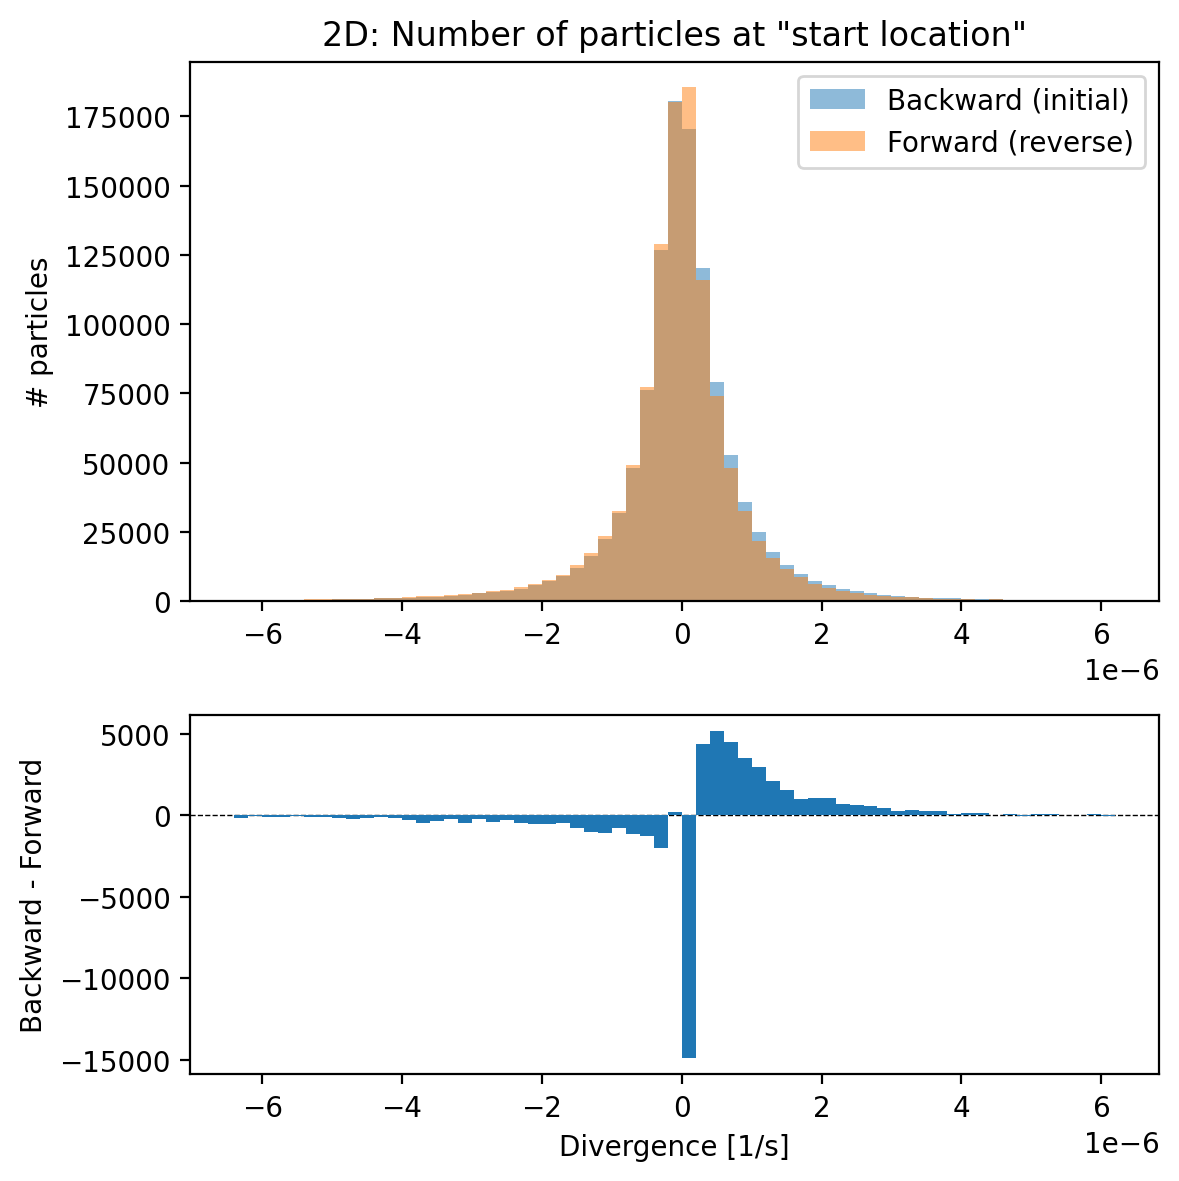

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), height_ratios=(1.5,1))
# ax.hist(divergence_forward_init.values, bins=np.linspace(-0.7e-5, 0.7e-5, 100), alpha=0.5, label='Forward', density=True,)
# ax.hist(divergence_backward_last.values, bins=np.linspace(-0.7e-5, 0.7e-5, 100), alpha=0.5, label='Backward', density=True,)
binwidth = 2e-7
bins = np.arange(-6.4e-6, 6.4e-6, binwidth)
hist_2d_backward, bins = np.histogram(divergence_2d_backward_init.values, bins=bins, density=False)
hist_2d_forward, bins = np.histogram(divergence_2d_forward_last.values, bins=bins, density=False)

ax[0].bar(bins[:-1], hist_2d_backward, width=binwidth, alpha=0.5, label='Backward (initial)', align='edge')
ax[0].bar(bins[:-1], hist_2d_forward, width=binwidth, alpha=0.5, label='Forward (reverse)', align='edge')
ax[0].legend()
ax[0].set_ylabel("# particles")
ax[0].set_title('2D: Number of particles at "start location"')
ax[1].set_xlabel('Divergence [1/s]')

ax[1].bar(bins[:-1], hist_2d_backward-hist_2d_forward, width=binwidth, align='edge')
ax[1].set_ylabel("Backward - Forward")
ax[1].axhline(0, color='black', zorder=0, linewidth=0.5, linestyle='--')

fig.tight_layout()

In [15]:
stats.ks_2samp(divergence_2d_backward_init.values, divergence_2d_forward_last.values)

KstestResult(statistic=0.030430435720923743, pvalue=0.0, statistic_location=1.2037162e-09, statistic_sign=-1)

In [38]:
divergence_3d_backward_init = ds_3d_backward_nocoast.isel(obs=0).dudx_linear + ds_3d_backward_nocoast.isel(obs=0).dvdy_linear
divergence_3d_forward_last = ds_3d_forward_180_nocoast.isel(obs=-1).dudx_linear + ds_3d_forward_180_nocoast.isel(obs=-1).dvdy_linear


In [39]:
divergence_3d_backward_init.to_netcdf("arrays/BF_divergence_3d_backward_init.nc")
divergence_3d_forward_last.to_netcdf("arrays/BF_divergence_3d_forward_last.nc")

In [ ]:


fig, ax = plt.subplots(2, 1, figsize=(6, 6), height_ratios=(1.5,1))

binwidth = 2e-7
bins = np.arange(-6.4e-6, 6.4e-6, binwidth)
hist_3d_backward, bins = np.histogram(divergence_3d_backward_init.values, bins=bins, density=False)
hist_3d_forward, bins = np.histogram(divergence_3d_forward_last.values, bins=bins, density=False)

ax[0].bar(bins[:-1], hist_3d_backward, width=binwidth, alpha=0.5, label='Backward (initial)', align='edge')
ax[0].bar(bins[:-1], hist_3d_forward, width=binwidth, alpha=0.5, label='Forward (reverse)', align='edge')
ax[0].legend()
ax[0].set_ylabel("# particles")
ax[0].set_title('3D: Number of particles at "start location"')
ax[1].set_xlabel('Divergence [1/s]')

ax[1].bar(bins[:-1], hist_3d_backward-hist_3d_forward, width=binwidth, align='edge')
ax[1].set_ylabel("Backward - Forward")
ax[1].axhline(0, color='black', zorder=0, linewidth=0.5, linestyle='--')

fig.tight_layout()

In [ ]:

binwidth = 2e-7
bins = np.arange(-6.4e-6, 6.4e-6, binwidth)
hist_3d_backward, bins = np.histogram(divergence_3d_backward_init.values, bins=bins, density=False)
hist_3d_forward, bins = np.histogram(divergence_3d_forward_last.values, bins=bins, density=False)

ax[0].bar(bins[:-1], hist_3d_backward, width=binwidth, alpha=0.5, label='Backward (initial)', align='edge')
ax[0].bar(bins[:-1], hist_3d_forward, width=binwidth, alpha=0.5, label='Forward (reverse)', align='edge')
ax[0].legend()
ax[0].set_ylabel("# particles")
ax[0].set_title('3D: Number of particles at "start location"')
ax[1].set_xlabel('Divergence [1/s]')

ax[1].bar(bins[:-1], hist_3d_backward-hist_3d_forward, width=binwidth, align='edge')
ax[1].set_ylabel("Backward - Forward")
ax[1].axhline(0, color='black', zorder=0, linewidth=0.5, linestyle='--')

fig.tight_layout()

In [17]:
stats.ks_2samp(divergence_3d_backward_init.values, divergence_3d_forward_last.values)

KstestResult(statistic=0.009635805486921306, pvalue=3.3118943472938974e-46, statistic_location=-4.8045166e-07, statistic_sign=-1)

# Plot on map

In [18]:
dx = dy = 1
lons = np.arange(-130, 61, dx)
lats = np.arange(-60, 81, dy)
LON, LAT = np.meshgrid(lons, lats)

lonsc = lons[:-1] + dx/2
latsc = lats[:-1] + dy/2
LONC, LATC = np.meshgrid(lonsc, latsc)

In [19]:
def countComparison(forward_init, backward_finit, LON, LAT):
    count_forward = np.histogram2d(forward_init.lon, forward_init.lat, bins=(lons, lats))[0]
    count_backward = np.histogram2d(backward_finit.lon, backward_finit.lat, bins=(lons, lats))[0]

    ratio = count_backward.T / count_forward.T
    lossgain = (count_backward.T - count_forward.T)/count_forward.max()

    lon_bindices_forward = np.digitize(forward_init.lon, lons[:-1]) - 1
    lat_bindices_forward = np.digitize(forward_init.lat, lats[:-1]) - 1
    lon_bindices_backward = np.digitize(backward_finit.lon, lons[:-1]) - 1
    lat_bindices_backward = np.digitize(backward_finit.lat, lats[:-1]) - 1

    flat_bin_indices_forward = lon_bindices_forward + lat_bindices_forward * (lons.size-1)
    flat_bin_indices_backward = lon_bindices_backward + lat_bindices_backward * (lons.size -1)

    same_bin = ((lon_bindices_forward == lon_bindices_backward) * (lat_bindices_forward == lat_bindices_backward))
    countgrid_bindices = np.arange(lons.size-1) + (lons.size-1) * np.arange(lats.size-1)[:, None]
    countgrid_bindices_flat = countgrid_bindices.flatten()

    counter_exact = np.zeros_like(countgrid_bindices_flat)

    for i, label in enumerate(flat_bin_indices_forward):
        if label == flat_bin_indices_backward[i]:
            counter_exact[label] += 1

    counter_exact_grid = counter_exact.reshape(lats.size-1, lons.size-1)
    counter_exact_grid = np.ma.masked_array(counter_exact_grid, mask=(count_forward==0).T)

    return count_forward, count_backward, ratio, lossgain, counter_exact_grid

In [20]:
# dont mind the parlance here; switch forward and backward
exp_dict = {"2D": {"forward" : {"ds" : ds_2d_backward_nocoast},
                    "backward" : {180 : {"ds" : ds_2d_forward_180_nocoast},
                                    90: {"ds" : ds_2d_forward_90_nocoast},
                                    30: {"ds" : ds_2d_forward_30_nocoast}, 
                                    10: {"ds" : ds_2d_forward_10_nocoast}
                                    }
                                    }, 
            "3D": {"forward" : {"ds" : ds_3d_backward_nocoast},
                    "backward" : {180 : {"ds" : ds_3d_forward_180_nocoast},
                                    90: {"ds" : ds_3d_forward_90_nocoast},
                                    30: {"ds" : ds_3d_forward_30_nocoast}, 
                                    10: {"ds" : ds_3d_forward_10_nocoast}
                                    }
                                    }, 
}

In [27]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0 #average
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

In [22]:
def mean_distance_per_bin(forward_init, backward_finit, lons, lats):
    distance = haversine(forward_init.lon.values, forward_init.lat.values, backward_finit.lon.values, backward_finit.lat.values)

    lon_bindices_forward = np.digitize(forward_init.lon.values, lons[:-1]) - 1
    lat_bindices_forward = np.digitize(forward_init.lat.values, lats[:-1]) - 1

    flat_bin_indices_forward = lon_bindices_forward + lat_bindices_forward * (lons.size-1)

    countgrid_bindices = np.arange(lons.size-1) + (lons.size-1) * np.arange(lats.size-1)[:, None]
    countgrid_bindices_flat = countgrid_bindices.flatten()

    distances = np.zeros_like(countgrid_bindices_flat, dtype=np.float64)
    counter = np.zeros_like(countgrid_bindices_flat, dtype=np.float64)

    # Use np.bincount to accumulate distances and counts
    np.add.at(distances, flat_bin_indices_forward, distance)
    np.add.at(counter, flat_bin_indices_forward, 1)

    # To avoid division by zero, use np.where to replace zero counters with ones before division
    mean_distances = (distances / counter).reshape(lats.size-1, lons.size-1)

    return mean_distances

In [23]:
def interpolate_to_regular_grid(orig_lon, orig_lat, orig_data, new_lon = LONC, new_lat = LATC, method='linear'):
    points = np.column_stack((orig_lon.ravel(), orig_lat.ravel()))
    values = orig_data.values.ravel()

    grid_points = np.column_stack((new_lon.ravel(), new_lat.ravel()))

    interpolated_data = griddata(points, values, grid_points, method=method)

    interpolated_data = interpolated_data.reshape(new_lon.shape)

    return interpolated_data

In [25]:
# coarsened_divergence_interpreg = interpolate_to_regular_grid(mesh_subset.glamt.values[6::12, 6::12], mesh_subset.gphit.values[6::12, 6::12], coarsened_divergence)
# coarsened_curl_interpreg = interpolate_to_regular_grid(mesh_subset.glamt.values[6::12, 6::12], mesh_subset.gphit.values[6::12, 6::12], coarsened_curl)
# coarsened_deriv_sum_interpreg = interpolate_to_regular_grid(mesh_subset.glamt.values[6::12, 6::12], mesh_subset.gphit.values[6::12, 6::12], coarsened_deriv_sum)


In [26]:
def nan_corrcoef_with_mask(x, y):
    if np.ma.isMaskedArray(x):
        mask_x = ~x.mask * np.isfinite(x)
    else:
        mask_x = np.isfinite(x)

    if np.ma.isMaskedArray(y):
        mask_y = ~y.mask * np.isfinite(y)
    else:
        mask_y = np.isfinite(y)

    common_mask = mask_x & mask_y
    x = x[common_mask]
    y = y[common_mask]

    if len(x) == 0 or len(y) == 0:
        return np.nan  
    corr_matrix = np.corrcoef(x, y)

    corr = corr_matrix[0, 1] 

    return corr

In [27]:
for dimension in ["2D", "3D"]:
    for timescale in [180, 90, 30, 10]:
        print(f"{dimension=}, {timescale=}")
        dum, dum, ratio, lossgain, counter_exact_grid = countComparison(exp_dict[dimension]['forward']['ds'].isel(obs=0), exp_dict[dimension]['backward'][timescale]['ds'].isel(obs=-1), LON, LAT)
        exp_dict[dimension]['backward'][timescale]['ratio'] = ratio
        exp_dict[dimension]['backward'][timescale]['lossgain'] = lossgain
        exp_dict[dimension]['backward'][timescale]['counter_exact_grid'] = counter_exact_grid
        exp_dict[dimension]['backward'][timescale]['mean_distance'] = mean_distance_per_bin(exp_dict[dimension]['forward']['ds'].isel(obs=0), exp_dict[dimension]['backward'][timescale]['ds'].isel(obs=-1), lons, lats)

dimension='2D', timescale=180


/tmp/ipykernel_16053/3080205450.py:5: RuntimeWarning: divide by zero encountered in divide
  ratio = count_backward.T / count_forward.T
/tmp/ipykernel_16053/3080205450.py:5: RuntimeWarning: invalid value encountered in divide
  ratio = count_backward.T / count_forward.T
/tmp/ipykernel_16053/967594165.py:20: RuntimeWarning: invalid value encountered in divide
  mean_distances = (distances / counter).reshape(lats.size-1, lons.size-1)


dimension='2D', timescale=90
dimension='2D', timescale=30
dimension='2D', timescale=10
dimension='3D', timescale=180
dimension='3D', timescale=90
dimension='3D', timescale=30
dimension='3D', timescale=10


In [46]:
for dimension in ["2D", "3D"]:
    for timescale in [180, 90, 30, 10]:
        for quantity in ['ratio', 'lossgain', 'counter_exact_grid', 'mean_distance']:
            exp_dict[dimension]['backward'][timescale][quantity].dump(f"arrays/{quantity}_BF_{dimension}_{timescale}.npy")
            # np.save(f"arrays/{quantity}_BF_{dimension}_{timescale}.npy", exp_dict[dimension]['backward'][timescale][quantity])

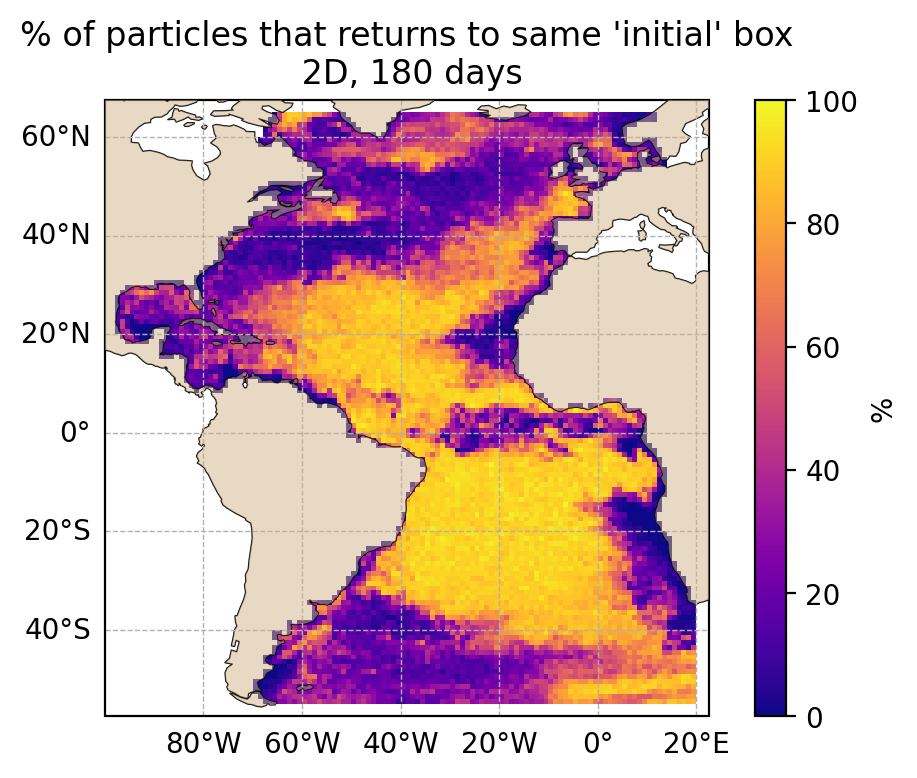

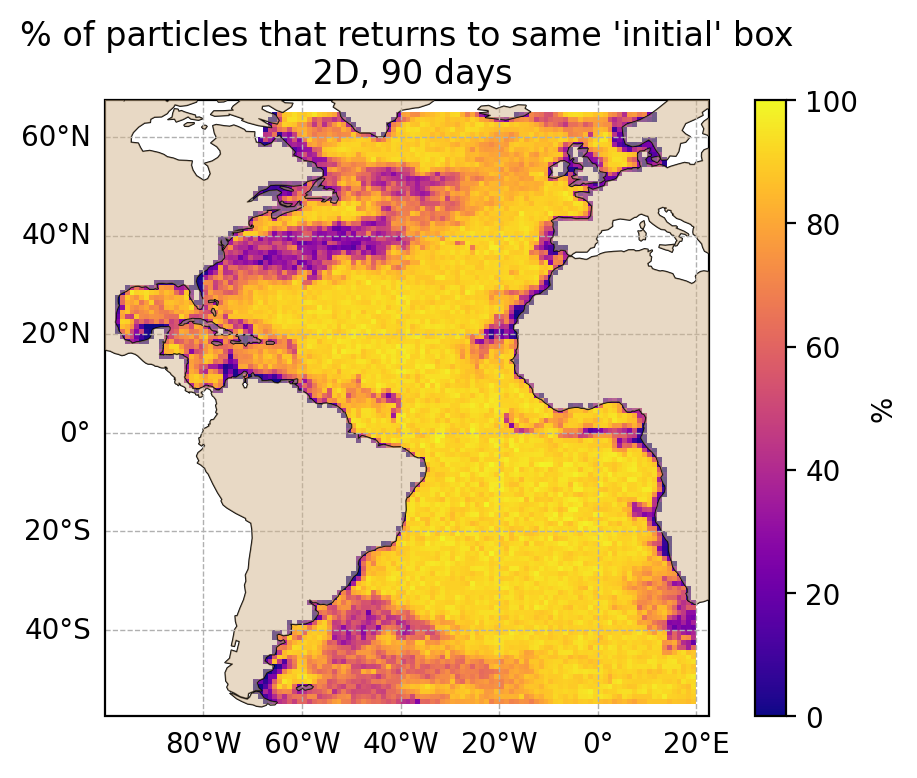

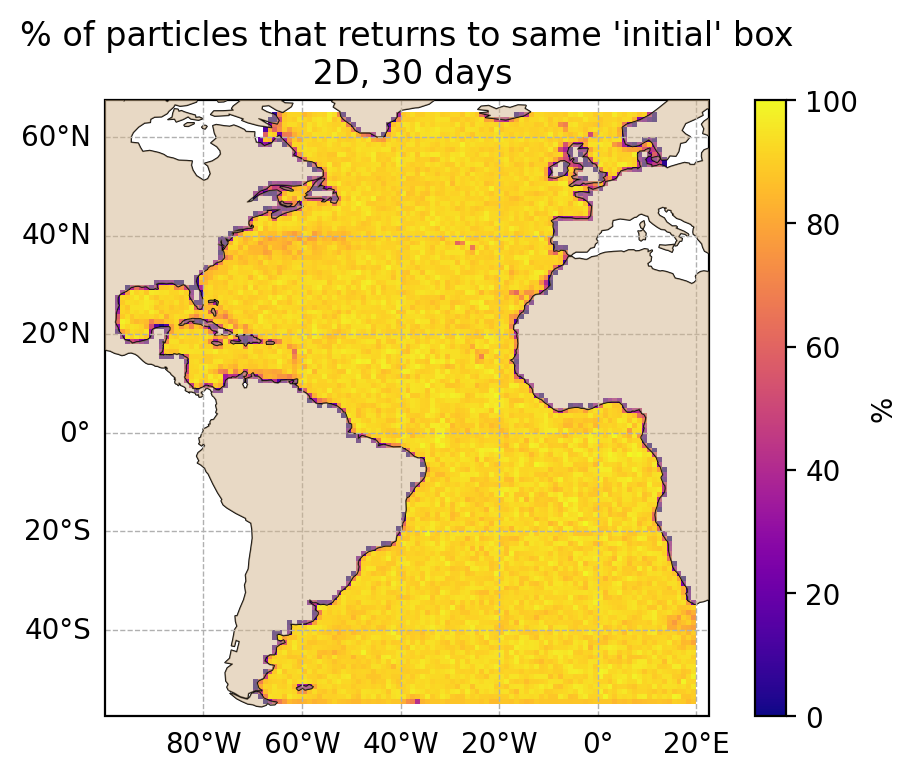

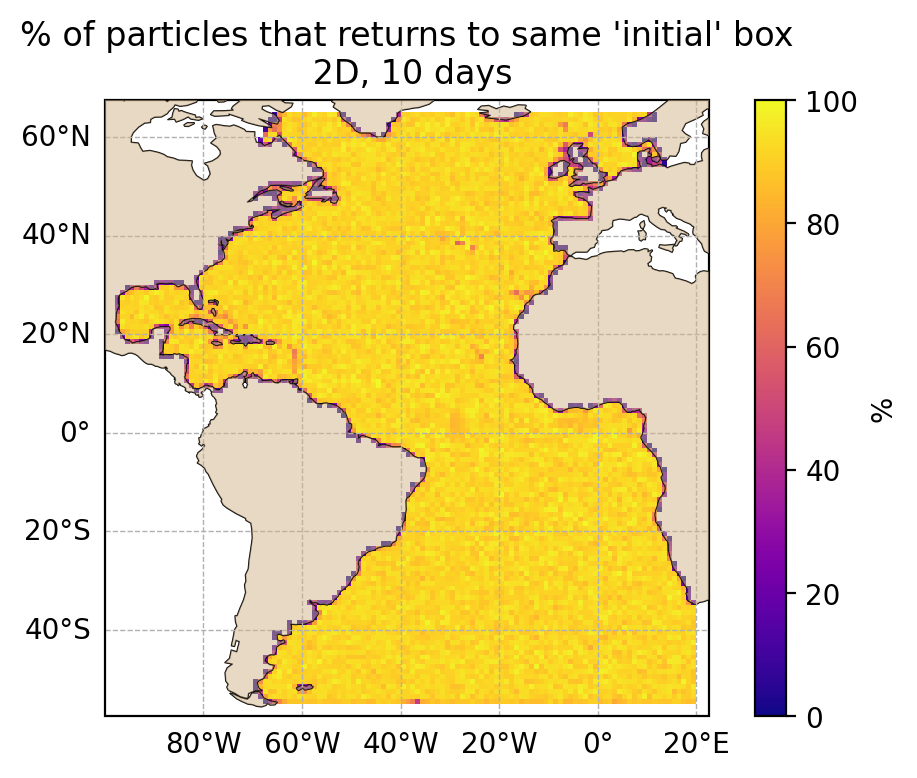

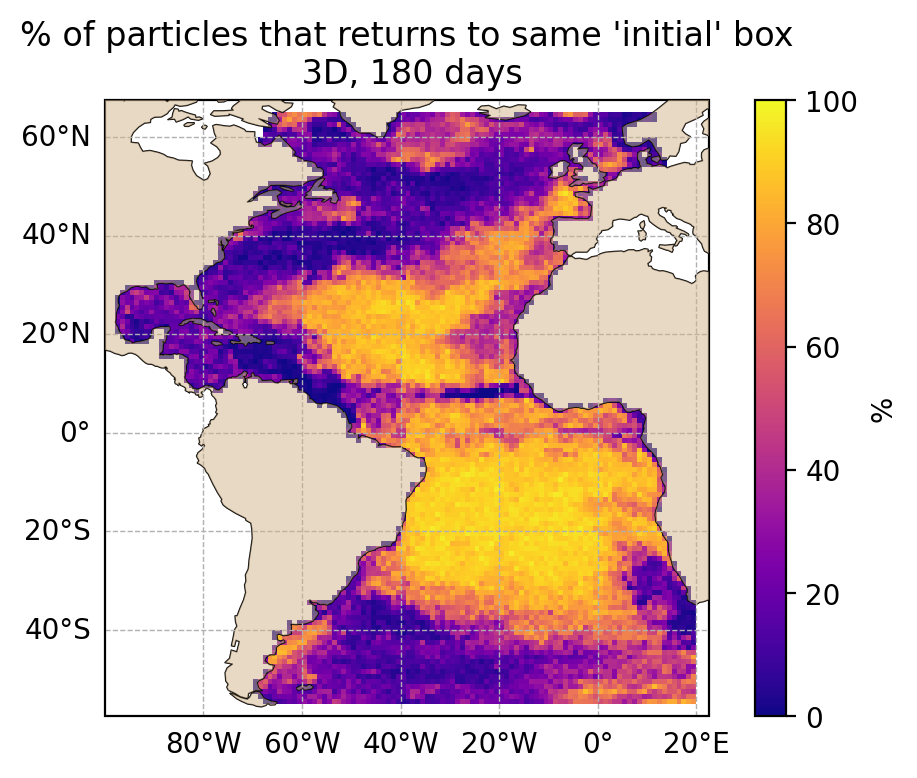

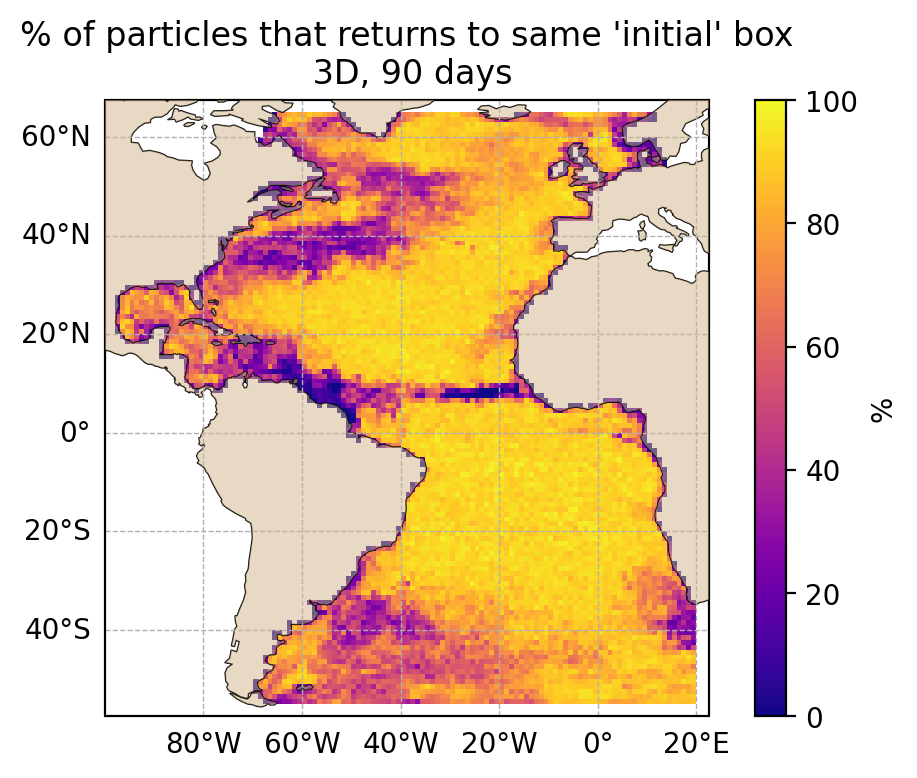

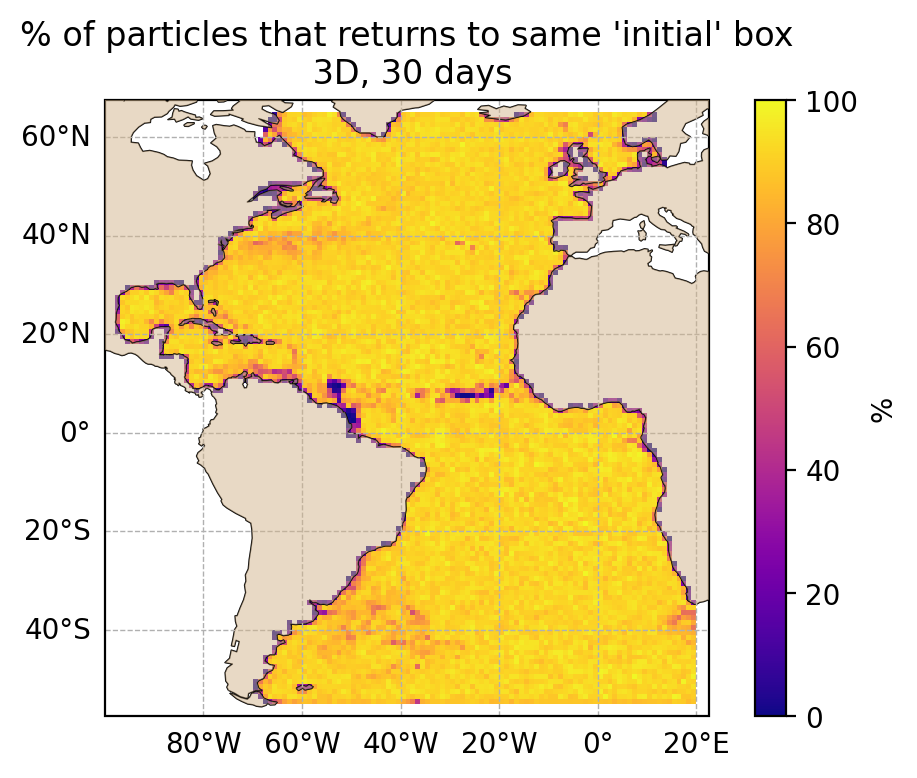

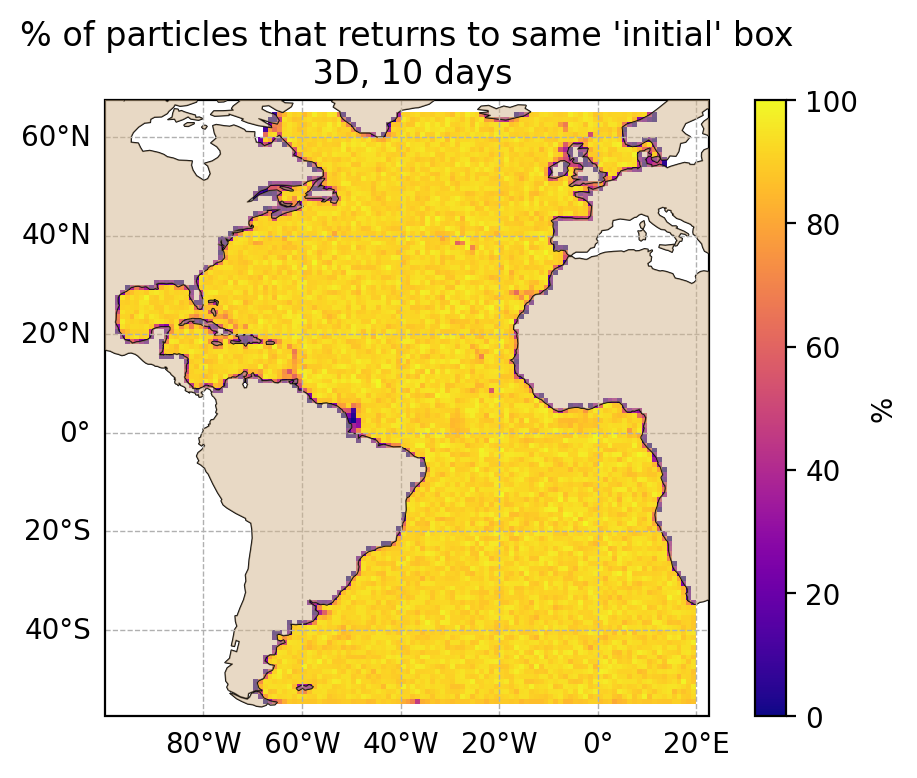

In [28]:
for dimension in ["2D", "3D"]:
    for timescale in [180, 90, 30, 10]:
        counter_exact_grid = exp_dict[dimension]['backward'][timescale]['counter_exact_grid']
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
        ax.coastlines(color='black', linewidth=0.5)
        ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
        ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
        ax.set_extent([-100, 22.5, -57.5, 67.5], crs=cart.crs.PlateCarree())
        count_plot = ax.pcolormesh(LON, LAT, counter_exact_grid/144 * 100, transform=cart.crs.PlateCarree(), cmap='plasma', label='Count', vmin=0, vmax=100)
        fig.colorbar(count_plot, ax=ax, label='%')
        ax.title.set_text(f"% of particles that returns to same 'initial' box\n {dimension}, {timescale} days")
        plt.savefig(f"figures/returns/return_exact_{dimension}_{timescale}d_backward.png", dpi=300)
        plt.show()

In [29]:
# for timescale in [180, 90, 30, 10]:
#     counter_exact_grid_2D = exp_dict['2D']['backward'][timescale]['counter_exact_grid']
#     counter_exact_grid_3D = exp_dict['3D']['backward'][timescale]['counter_exact_grid']

#     fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
#     ax.coastlines(color='black', linewidth=0.5)
#     ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
#     ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
#     ax.set_extent([-100, 22.5, -57.5, 67.5], crs=cart.crs.PlateCarree())

#     count_plot = ax.pcolormesh(LON, LAT, (counter_exact_grid_3D - counter_exact_grid_2D)/144 * 100, transform=cart.crs.PlateCarree(), cmap='RdBu_r', label='Count', vmin=-100, vmax=100)
#     fig.colorbar(count_plot, ax=ax, label='%')
#     ax.title.set_text(f"% of particles that returns to same 'initial' box\n Difference 3D-2D, {timescale} days")
#     plt.savefig(f"figures/returns/return_exact_3D-2D_{timescale}d.png", dpi=300)
#     plt.show()

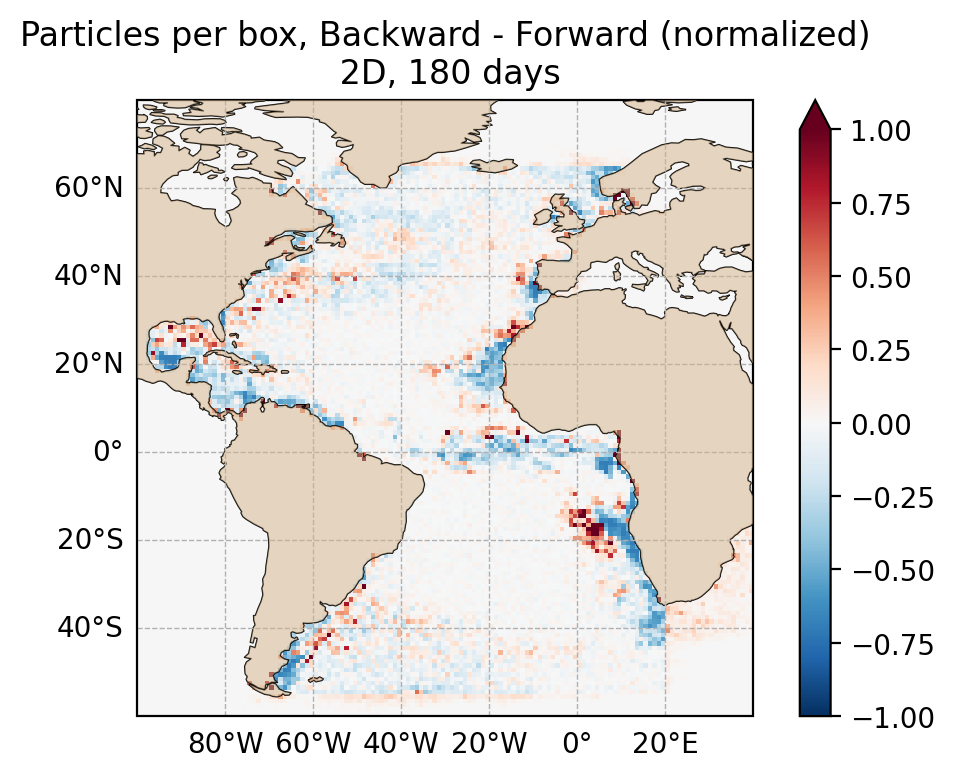

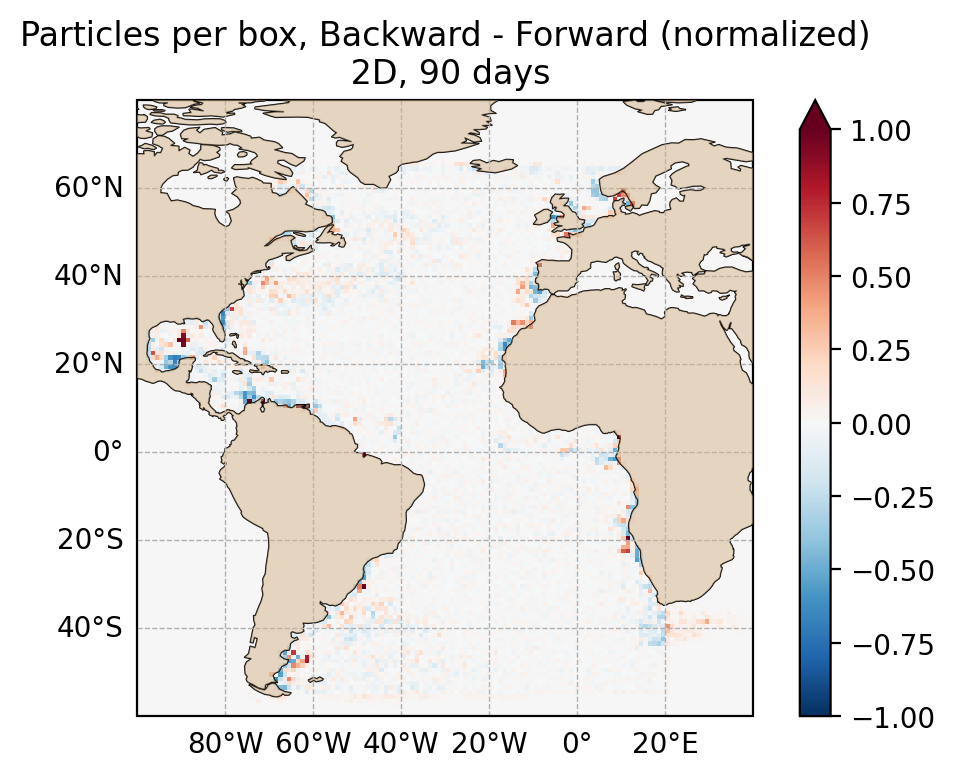

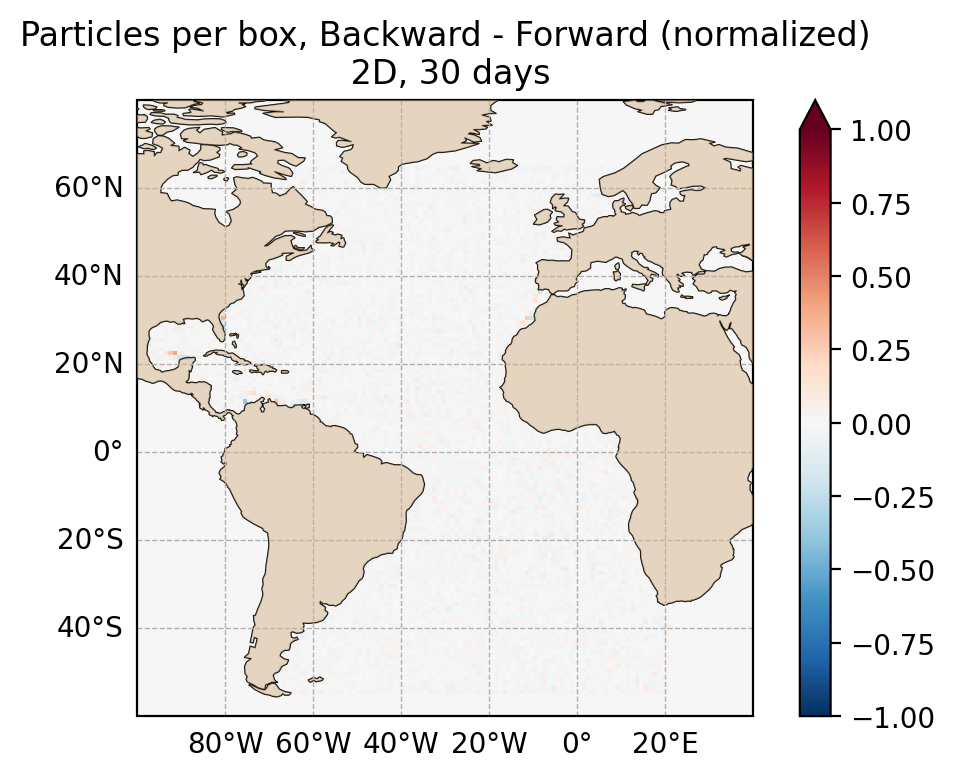

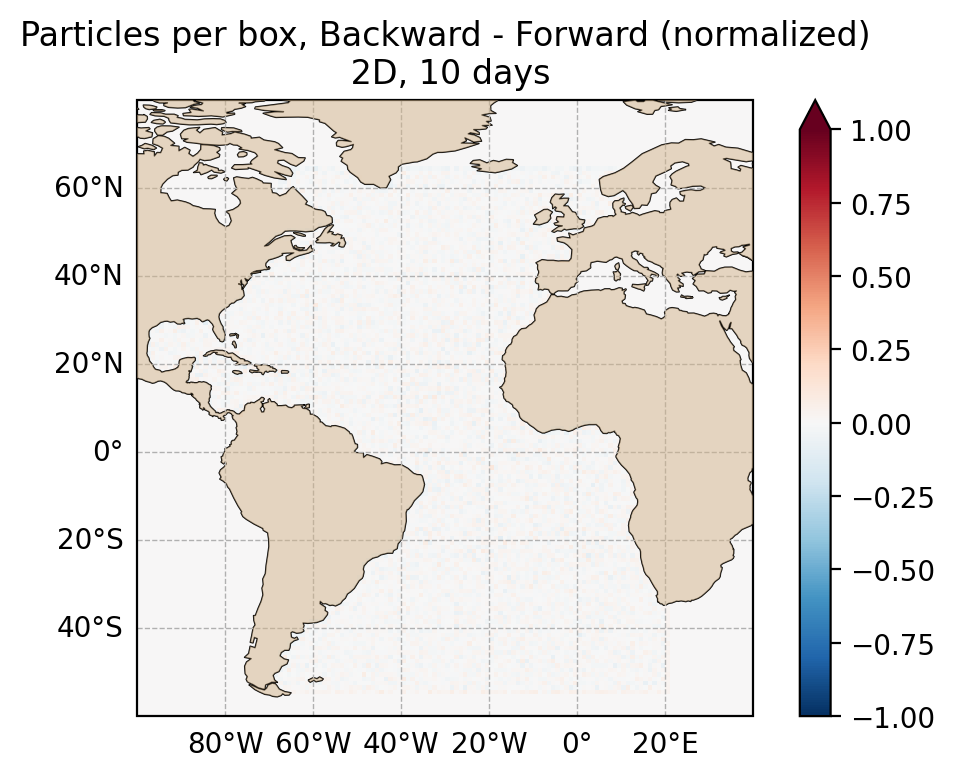

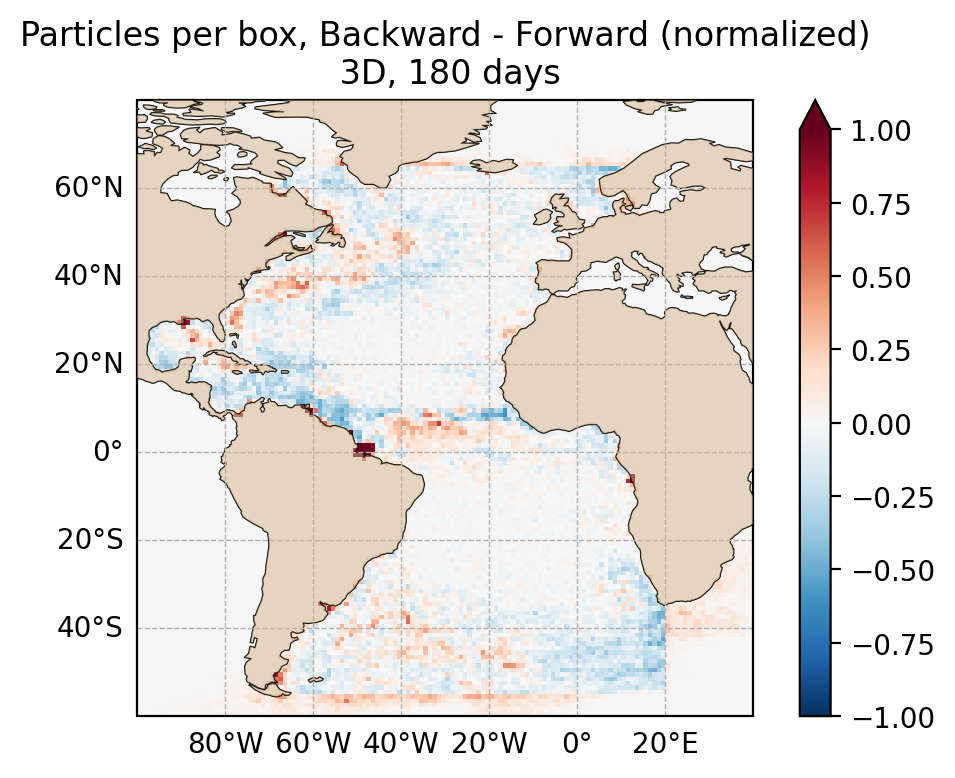

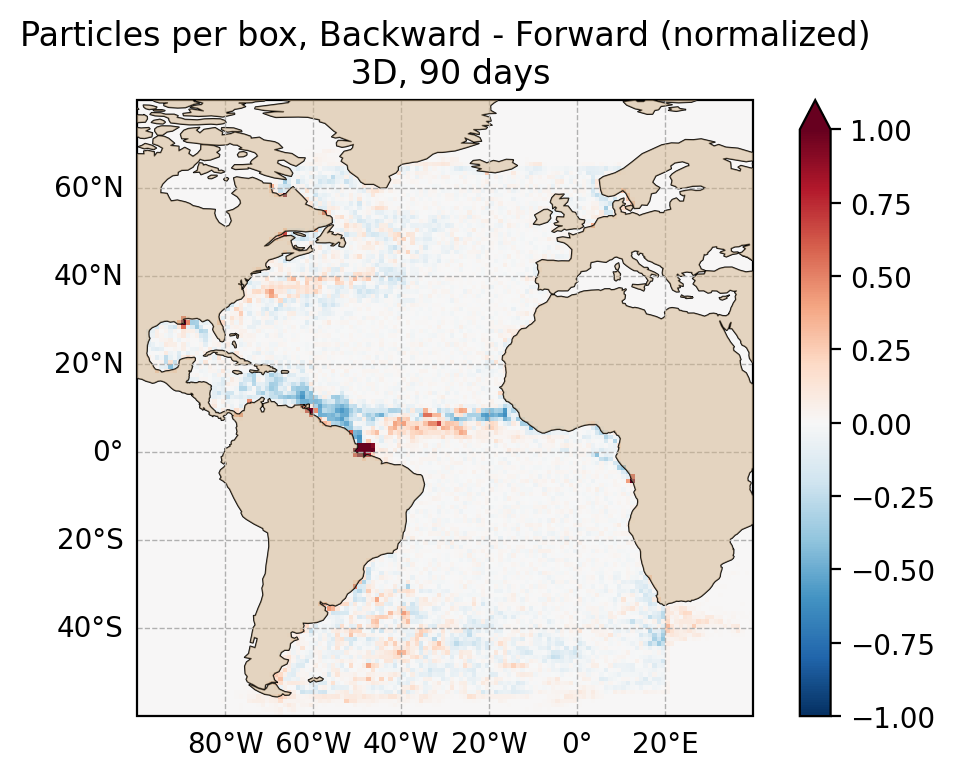

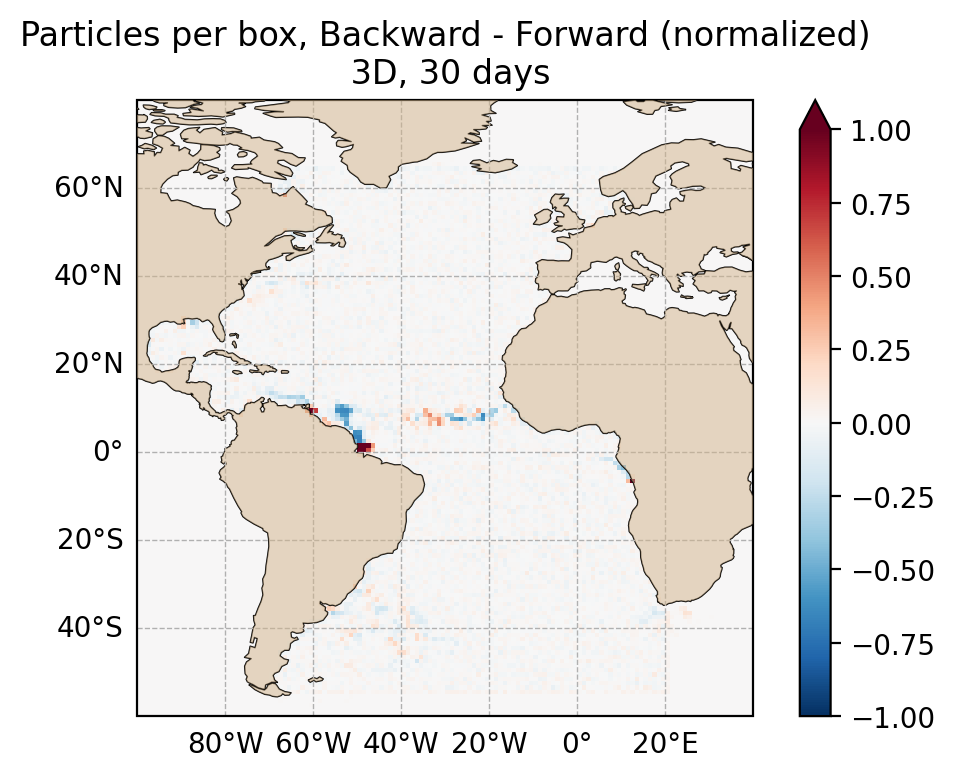

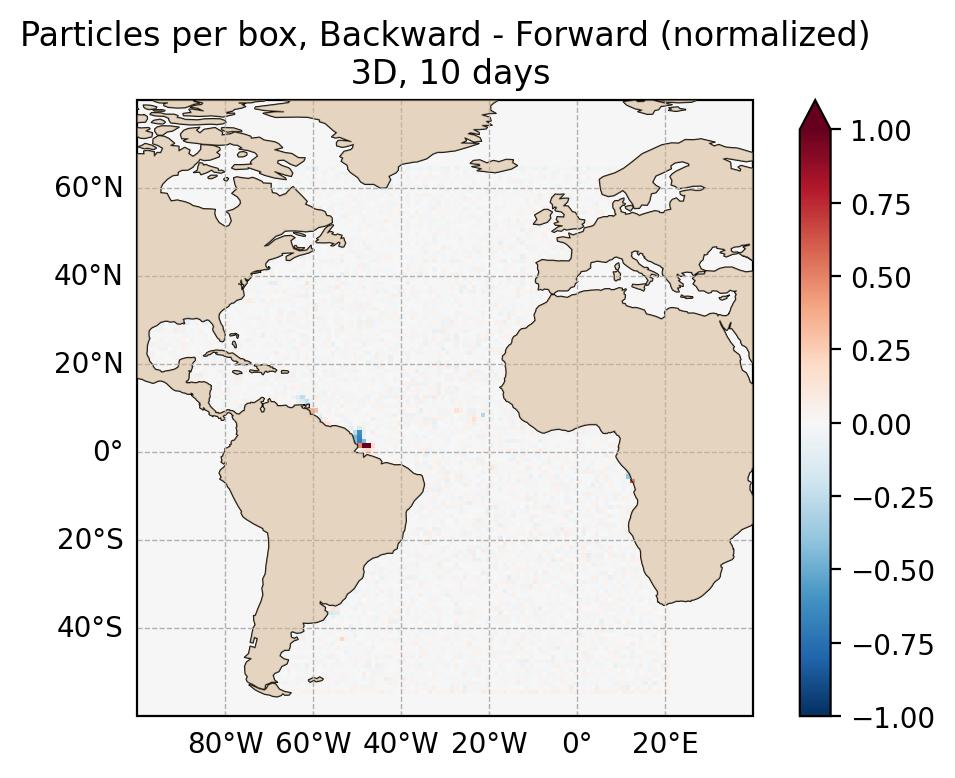

In [31]:
for dimension in ["2D", "3D"]:
    for timescale in [180, 90, 30, 10]:
        lossgain = exp_dict[dimension]['backward'][timescale]['lossgain']
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
        ax.coastlines(color='black', linewidth=0.5)
        ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
        ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
        ax.set_extent([-100, 40, -60, 80], crs=cart.crs.PlateCarree())
        count_plot = ax.pcolormesh(LON, LAT, lossgain/144 * 100, transform=cart.crs.PlateCarree(), cmap='RdBu_r', label='Count', vmin=-1, vmax=1)
        fig.colorbar(count_plot, ax=ax, label='', extend='max')
        ax.title.set_text(f"Particles per box, Backward - Forward (normalized)\n {dimension}, {timescale} days")
        plt.savefig(f"figures/returns/histogram_{dimension}_{timescale}d_backward.png", dpi=300)
        plt.show()

In [32]:
# for timescale in [180, 90, 30, 10]:
#     lossgain_2D = exp_dict['2D']['backward'][timescale]['lossgain']
#     lossgain_3D = exp_dict['3D']['backward'][timescale]['lossgain']

#     fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
#     ax.coastlines(color='black', linewidth=0.5)
#     ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
#     ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
#     ax.set_extent([-100, 40, -60, 80], crs=cart.crs.PlateCarree())
#     count_plot = ax.pcolormesh(LON, LAT, (lossgain_3D - lossgain_2D)/144 * 100, transform=cart.crs.PlateCarree(), cmap='RdBu_r', label='Count', vmin=-1, vmax=1)
#     fig.colorbar(count_plot, ax=ax, label='')
#     ax.title.set_text(f"Particles per box, Backward - Forward (normalized)\n Difference 3D-2D, {timescale} days")
#     plt.savefig(f"figures/returns/histogram_3D-2D_{timescale}d.png", dpi=300)
#     plt.show()

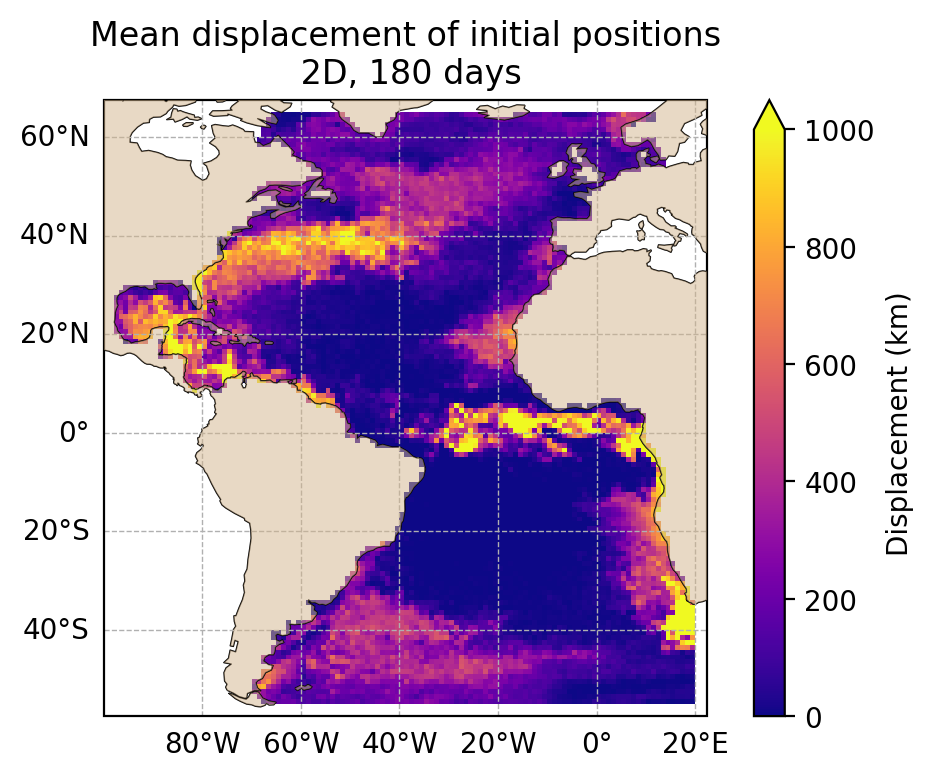

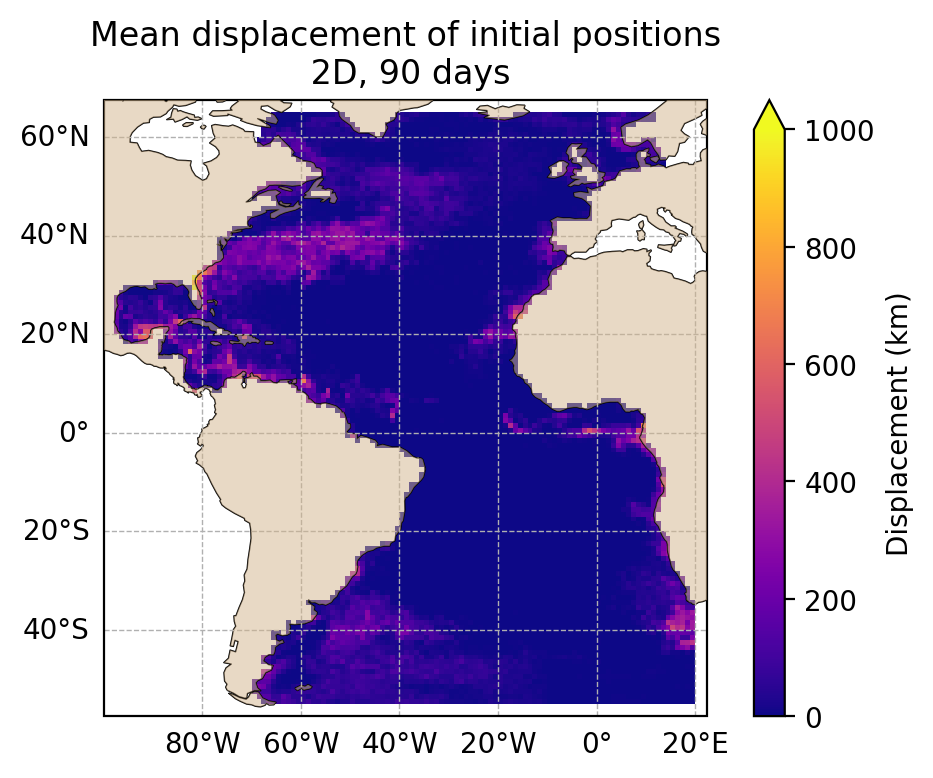

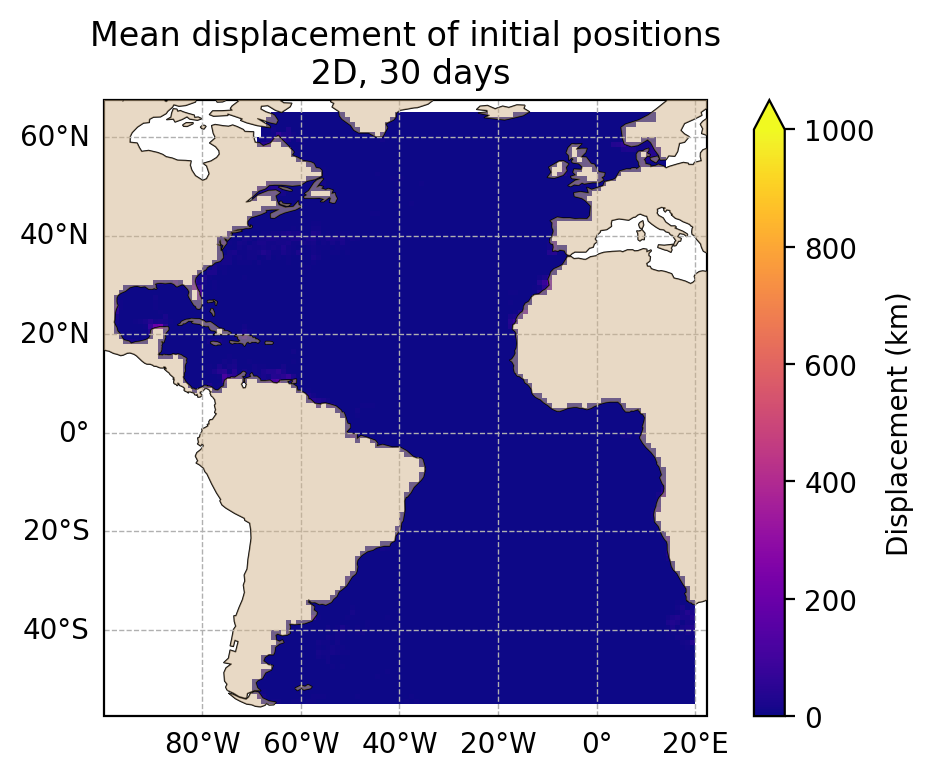

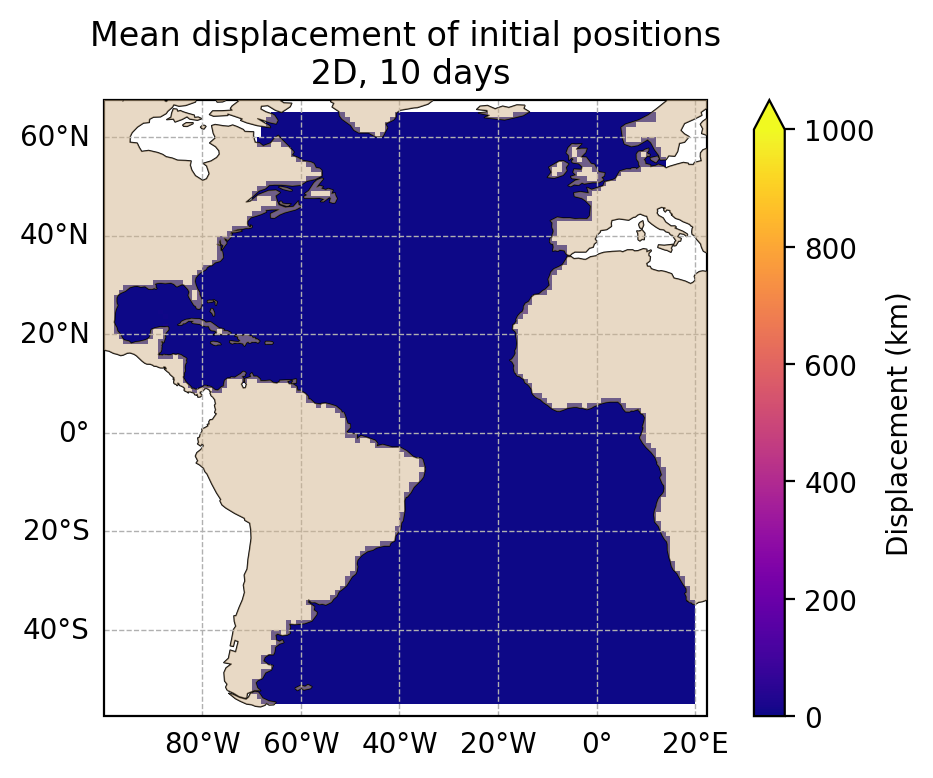

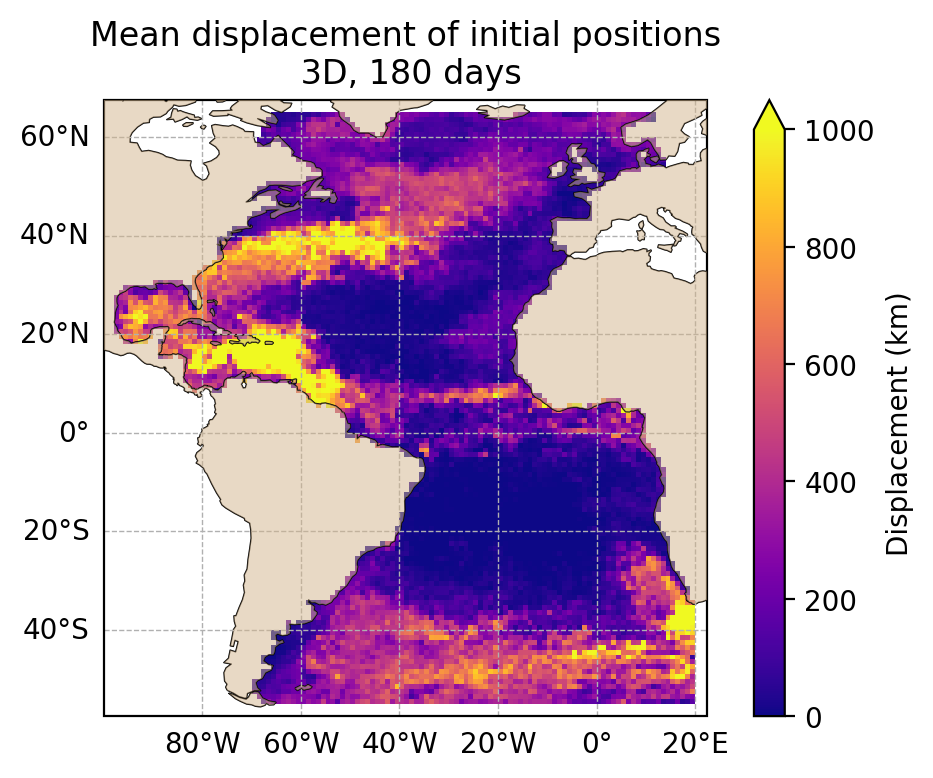

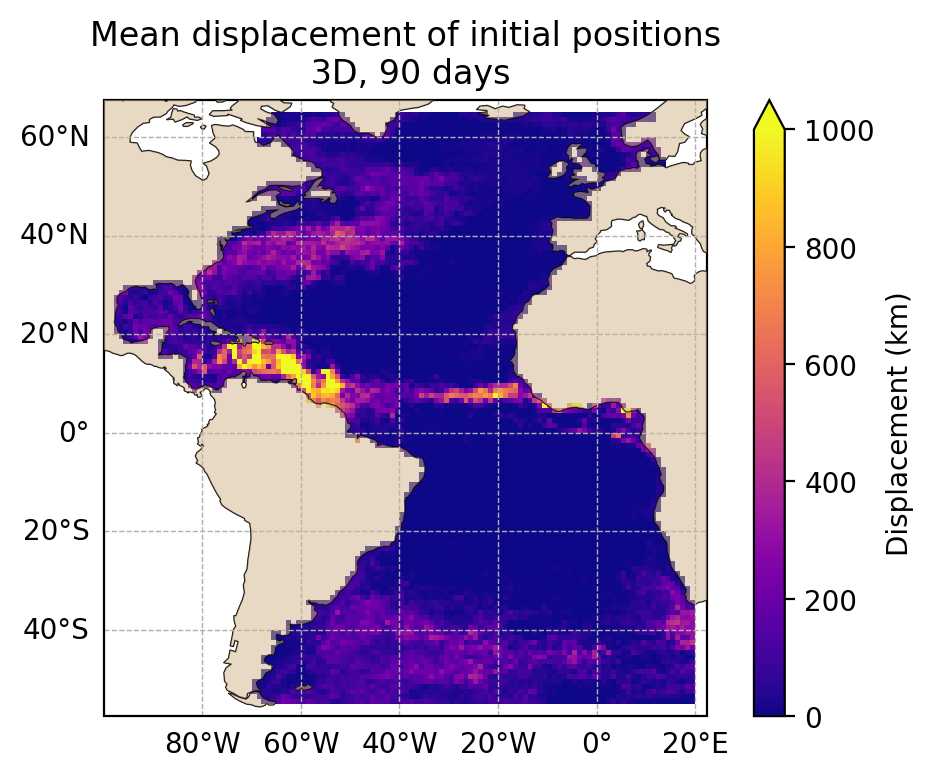

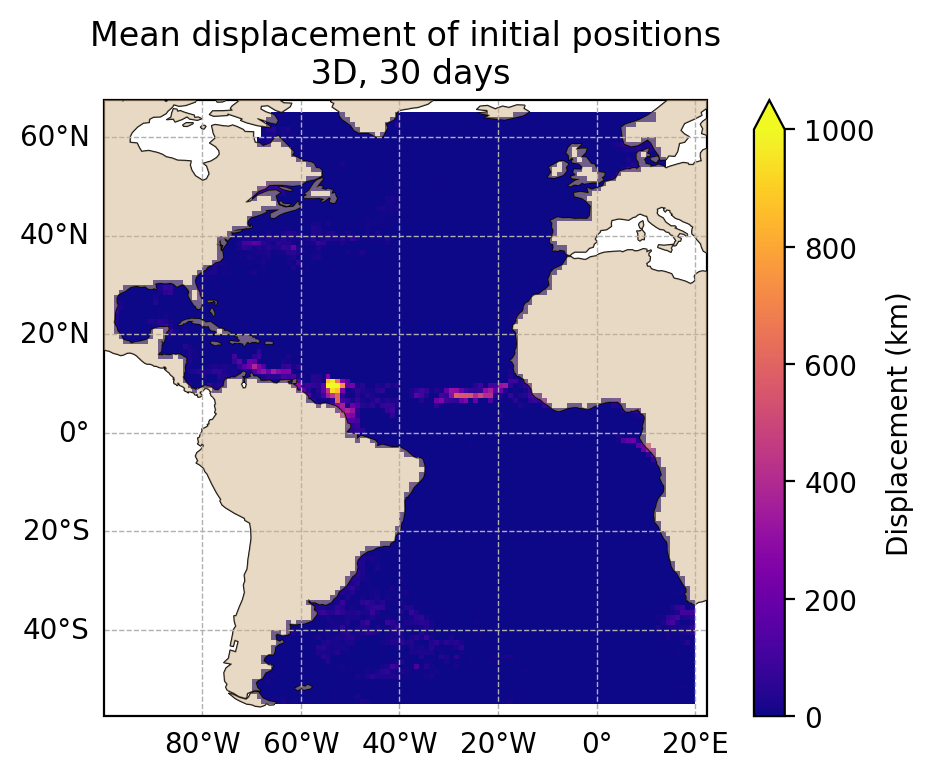

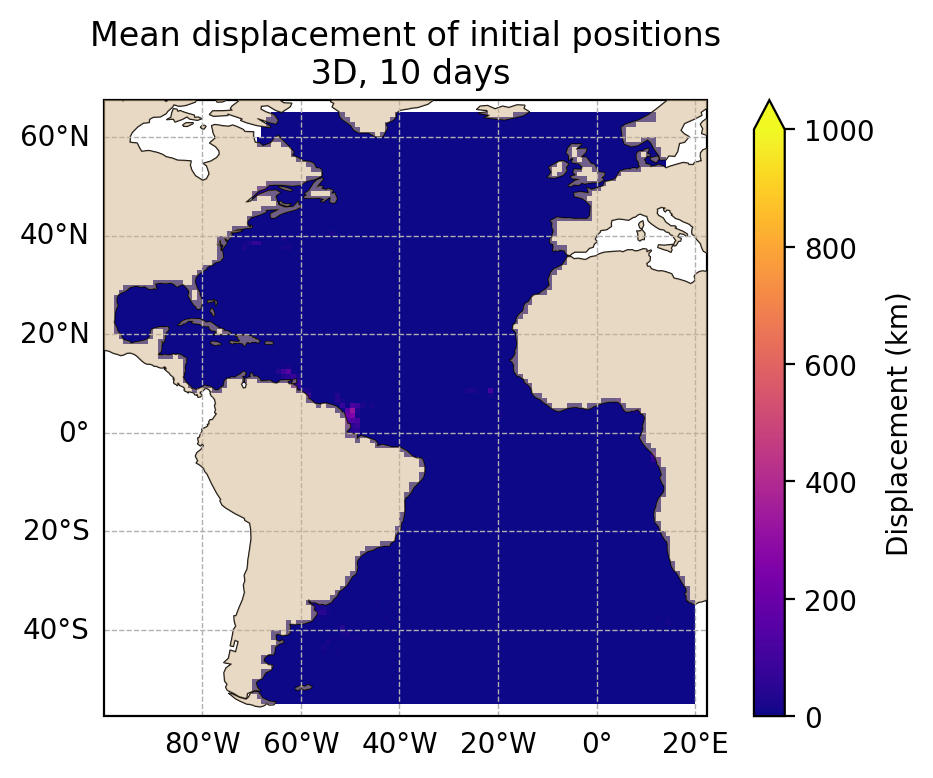

In [33]:
for dimension in ["2D", "3D"]:
    for timescale in [180, 90, 30, 10]:
        mean_distance = exp_dict[dimension]['backward'][timescale]['mean_distance']
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
        ax.coastlines(color='black', linewidth=0.5)
        ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
        ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
        ax.set_extent([-100, 22.5, -57.5, 67.5], crs=cart.crs.PlateCarree())
        count_plot = ax.pcolormesh(LON, LAT, mean_distance, transform=cart.crs.PlateCarree(), cmap='plasma', vmin=0, vmax=1000)
        fig.colorbar(count_plot, ax=ax, label='Displacement (km)', extend='max')
        ax.title.set_text(f"Mean displacement of initial positions\n {dimension}, {timescale} days")
        plt.savefig(f"figures/returns/haversine_{dimension}_{timescale}d_backw.png", dpi=300, bbox_inches='tight')
        plt.show()

# Inspect trajectories near rivers

In [ ]:
# ds_3d_backward_nocoast = ds_3d_backward.isel(trajectory=(ds_3d_backward.isel(obs=0).drop('obs').coastal == 0))
# ds_3d_forward_180_nocoast = ds_3d_forward_180.sel(trajectory=ds_3d_backward_nocoast.trajectory.values)
# ds_3d_forward_90_nocoast = ds_3d_forward_90.isel(trajectory=ds_3d_backward_nocoast.trajectory.values)
# ds_3d_forward_30_nocoast = ds_3d_forward_30.isel(trajectory=ds_3d_backward_nocoast.trajectory.values)
# ds_3d_forward_10_nocoast = ds_3d_forward_10.isel(trajectory=ds_3d_backward_nocoast.trajectory.values)

In [10]:
ds_3d_backward_nocoast

<xarray.Dataset>
Dimensions:        (trajectory: 1135245, obs: 181)
Coordinates:
  * obs            (obs) int32 0 1 2 3 4 5 6 7 ... 174 175 176 177 178 179 180
    time           (obs) datetime64[ns] 2015-07-31 2015-07-30 ... 2015-02-01
  * trajectory     (trajectory) int64 7 8 9 10 ... 1139076 1139077 1139078
Data variables: (12/13)
    U_save_linear  (trajectory, obs) float32 0.4637 0.3195 ... -0.02619 -0.04187
    V_save_linear  (trajectory, obs) float32 0.4197 0.08365 0.1981 ... 0.0 0.0
    W_save_linear  (trajectory, obs) float32 -1.244e-05 -1.483e-06 ... 0.0 0.0
    bathymetry     (trajectory, obs) float32 23.0 19.0 19.0 19.0 ... 0.0 0.0 0.0
    coastal        (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dudx_linear    (trajectory, obs) float32 -2.693e-05 1.142e-06 ... 9.172e-06
    ...             ...
    dvdx_linear    (trajectory, obs) float32 -1.779e-05 -2.59e-05 ... 0.0 0.0
    dvdy_linear    (trajectory, obs) float32 4.697e-06 -7.119e-06 ... 0.0 0.0
    lat            (trajectory, obs) float64 -54.92 -54.98 ... 64.92 64.92
    lon            (trajectory, obs) float64 -65.25 -65.89 ... 11.25 11.25
    ssh            (trajectory, obs) float32 -0.05326 -0.03536 ... 0.0 0.0
    z              (trajectory, obs) float64 0.494 0.6333 0.7839 ... 0.494 0.494
Attributes:
    2D or 3D:                            3D
    Conventions:                         CF-1.6/CF-1.7
    Initialization time (original run):  2015-07-31
    Integration time:                    180
    Output timestep:                     1
    Particles initialized from:          /nethome/4302001/backtracking_play/m...
    Timestep:                            -600
    feature_type:                        trajectory
    ncei_template_version:               NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:                     gradient_sampling_particle_simple_3D...
    parcels_mesh:                        spherical
    parcels_version:                     3.0.1

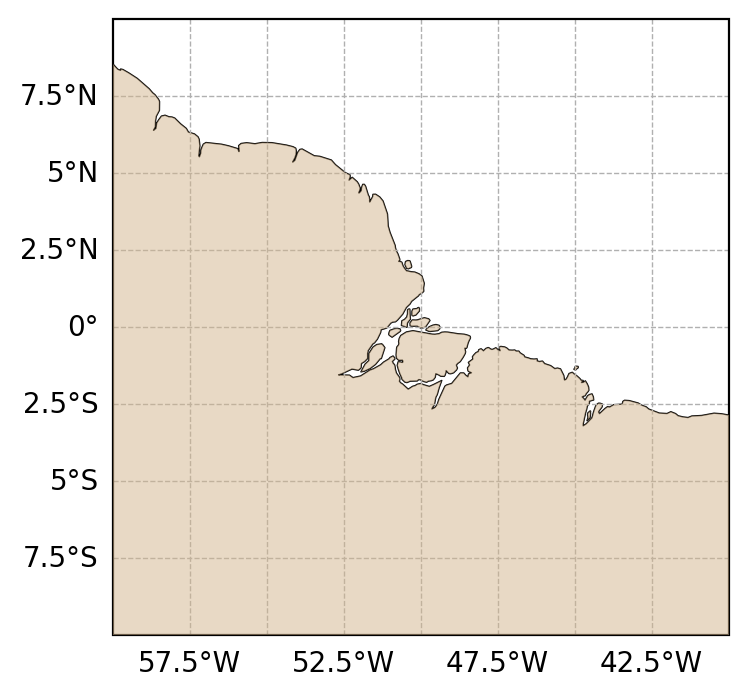

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ax.coastlines(color='black', linewidth=0.5)
ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
ax.set_extent([-60, -40, -10, 10], crs=cart.crs.PlateCarree())

In [11]:
submask = ((ds_3d_backward_nocoast.isel(obs=0).lon < -40) &
              (ds_3d_backward_nocoast.isel(obs=0).lon > -60) &
              (ds_3d_backward_nocoast.isel(obs=0).lat < 10) &
              (ds_3d_backward_nocoast.isel(obs=0).lat > -10))

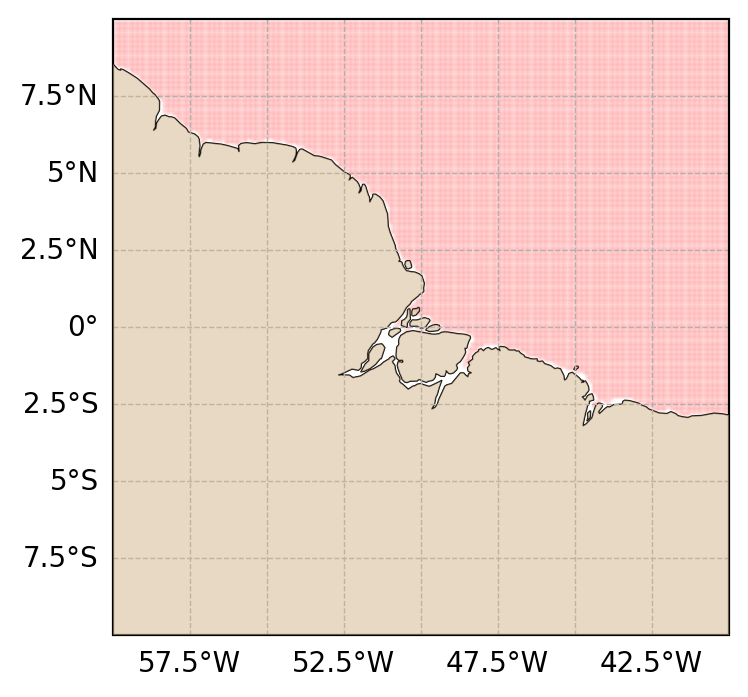

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ax.coastlines(color='black', linewidth=0.5)
ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
ax.set_extent([-60, -40, -10, 10], crs=cart.crs.PlateCarree())
ax.scatter(ds_3d_backward_nocoast.isel(obs=0).lon[submask], ds_3d_backward_nocoast.isel(obs=0).lat[submask], transform=cart.crs.PlateCarree(), s=1, color='red', label='Initial', alpha=0.05)

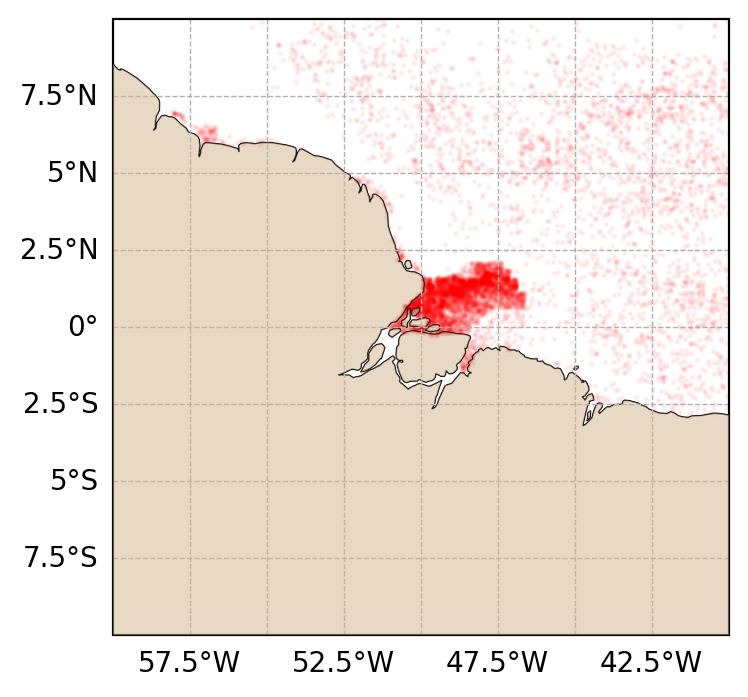

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ax.coastlines(color='black', linewidth=0.5)
ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
ax.set_extent([-60, -40, -10, 10], crs=cart.crs.PlateCarree())
ax.scatter(ds_3d_backward_nocoast.isel(obs=-1).lon[submask], ds_3d_backward_nocoast.isel(obs=-1).lat[submask], transform=cart.crs.PlateCarree(), s=1, color='red', label='Initial', alpha=0.05)

See which particles are stuck near the amazon

In [46]:
amaz_attracted = ((ds_3d_backward_nocoast.isel(obs=-1).lon > -52) & 
                    (ds_3d_backward_nocoast.isel(obs=-1).lon < -46) & 
                    (ds_3d_backward_nocoast.isel(obs=-1).lat < 2.5) & 
                    (ds_3d_backward_nocoast.isel(obs=-1).lat > -2.5))


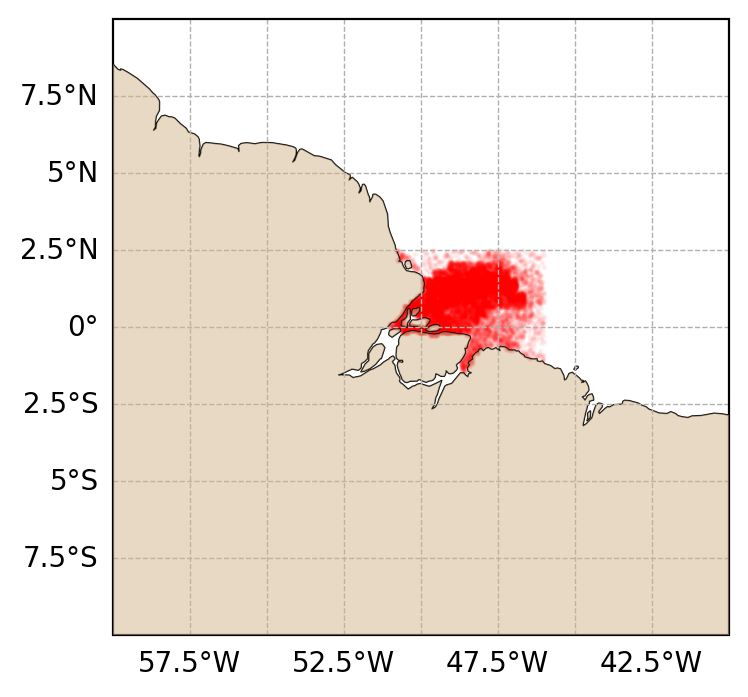

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ax.coastlines(color='black', linewidth=0.5)
ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
ax.set_extent([-60, -40, -10, 10], crs=cart.crs.PlateCarree())
ax.scatter(ds_3d_backward_nocoast.isel(obs=-1).lon[amaz_attracted], ds_3d_backward_nocoast.isel(obs=-1).lat[amaz_attracted], transform=cart.crs.PlateCarree(), s=1, color='red', label='Initial', alpha=0.05)

and see how these particles evolve forward in time

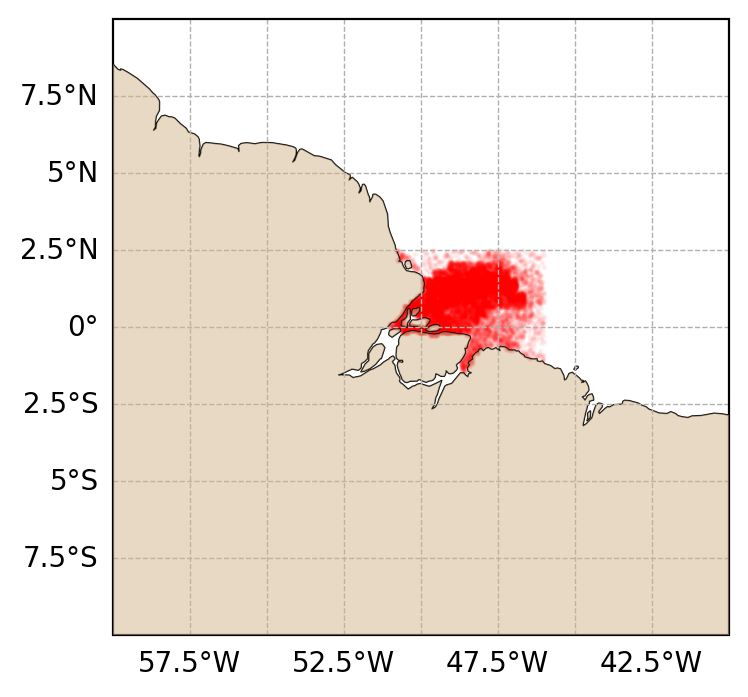

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ax.coastlines(color='black', linewidth=0.5)
ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
ax.set_extent([-60, -40, -10, 10], crs=cart.crs.PlateCarree())
ax.scatter(ds_3d_forward_180_nocoast.isel(obs=0).lon[amaz_attrackted], ds_3d_forward_180_nocoast.isel(obs=0).lat[amaz_attrackted], transform=cart.crs.PlateCarree(), s=1, color='red', label='Initial', alpha=0.05)

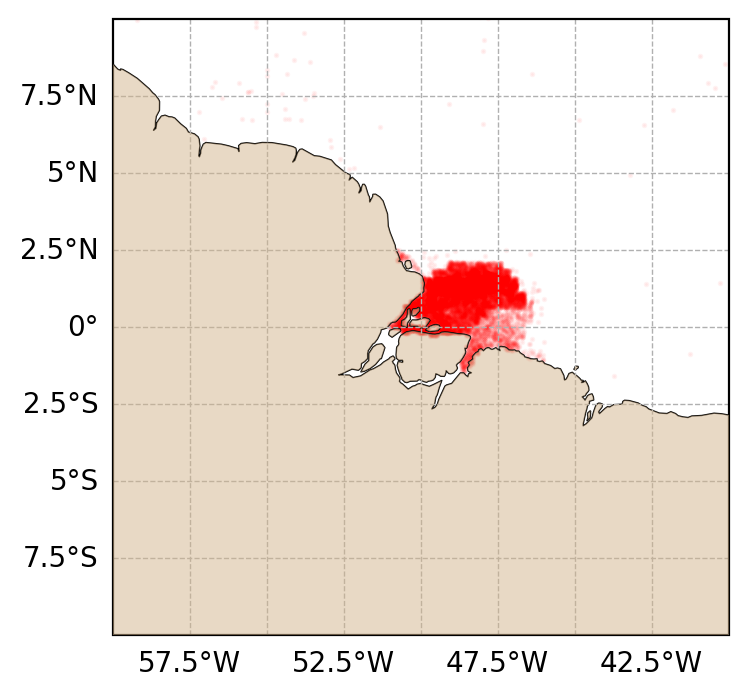

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ax.coastlines(color='black', linewidth=0.5)
ax.add_feature(cart.feature.LAND, zorder=10, facecolor='tan', alpha=0.5)
ax.gridlines(draw_labels=["left", "bottom"], linewidth=0.5, linestyle='--')
ax.set_extent([-60, -40, -10, 10], crs=cart.crs.PlateCarree())
ax.scatter(ds_3d_forward_180_nocoast.isel(obs=-1).lon[amaz_attrackted], ds_3d_forward_180_nocoast.isel(obs=-1).lat[amaz_attrackted], transform=cart.crs.PlateCarree(), s=1, color='red', label='Initial', alpha=0.05)

In [50]:
haversine_attracted = haversine(lon1 = ds_3d_forward_180_nocoast.isel(obs=0).lon[amaz_attrackted], 
                                lat1 = ds_3d_forward_180_nocoast.isel(obs=0).lat[amaz_attrackted],
                                lon2 = ds_3d_forward_180_nocoast.isel(obs=-1).lon[amaz_attrackted], 
                                lat2 = ds_3d_forward_180_nocoast.isel(obs=-1).lat[amaz_attrackted])

In [57]:
stuck = (haversine_attracted < 0.001)
stuck.sum()

<xarray.DataArray ()>
array(12514)

In [61]:
np.isnan(ds_3d_forward_180_nocoast.isel(obs=0).z[amaz_attracted][stuck]).sum()

<xarray.DataArray 'z' ()>
array(0)
Coordinates:
    obs      int32 0
    time     datetime64[ns] 2015-02-01

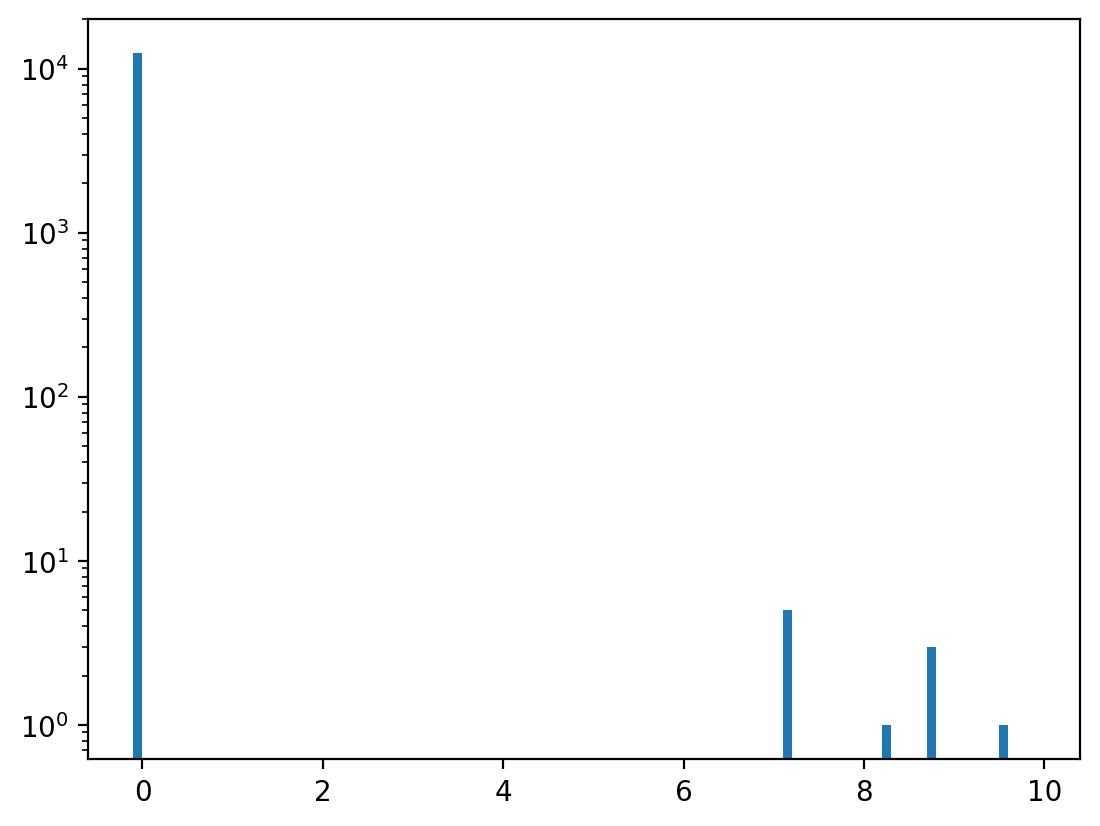

In [64]:
plt.hist(ds_3d_forward_180_nocoast.isel(obs=0).z[amaz_attracted][stuck], bins=np.arange(-0.1, 10, 0.1))
plt.gca().set_yscale('log')

In [69]:
mesh_z = xr.open_dataset("/nethome/4302001/local_data/mesh/PSY4V3R1_mesh_zgr_t0.nc")

In [103]:
ds_w_dummy = xr.open_dataset("/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_W_2015-02-01.nc")

In [107]:
ds_eta_dummy = xr.open_dataset("/storage2/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_2D_2015-02-01.nc")

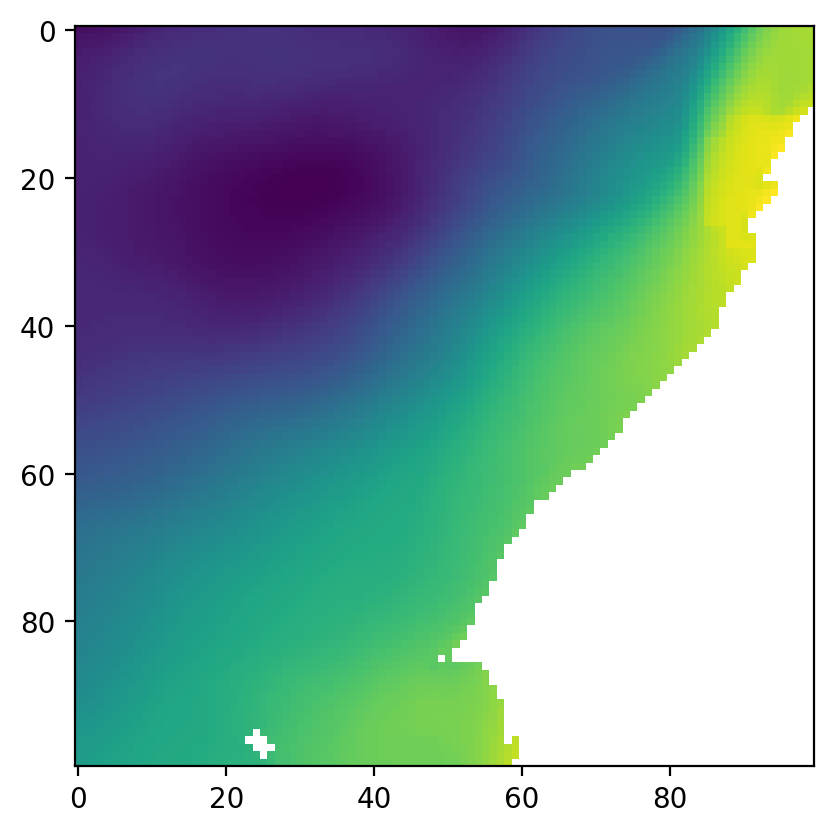

In [111]:
plt.imshow(ds_eta_dummy.sossheig.isel(deptht=0)[1400:1500, 3500:3600])

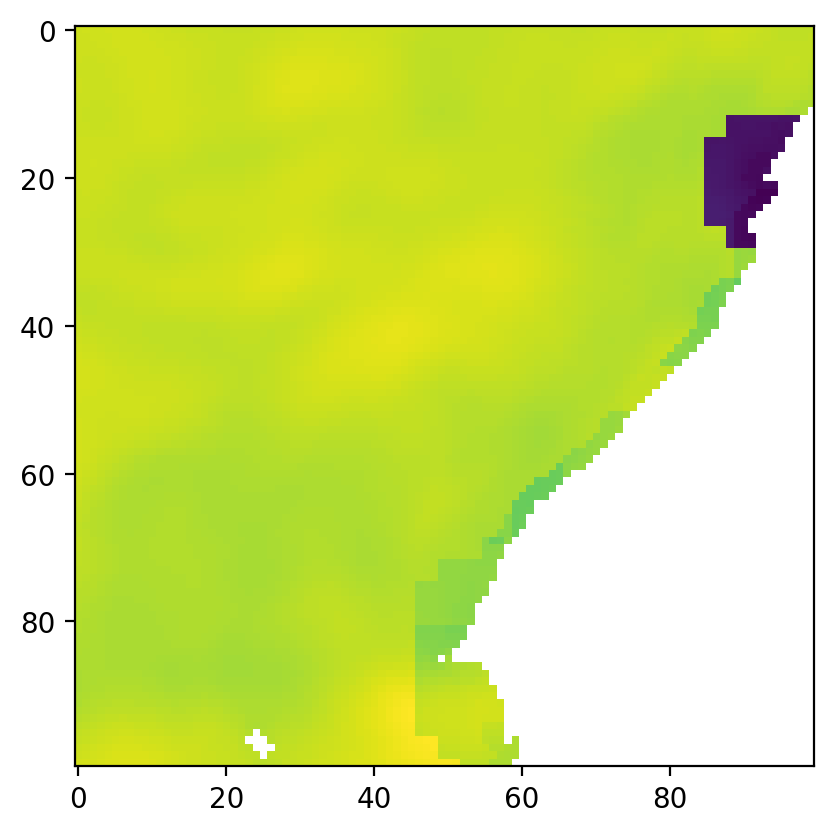

In [104]:
plt.imshow(ds_w_dummy.isel(depthw=0).vovecrtz[1400:1500, 3500:3600])


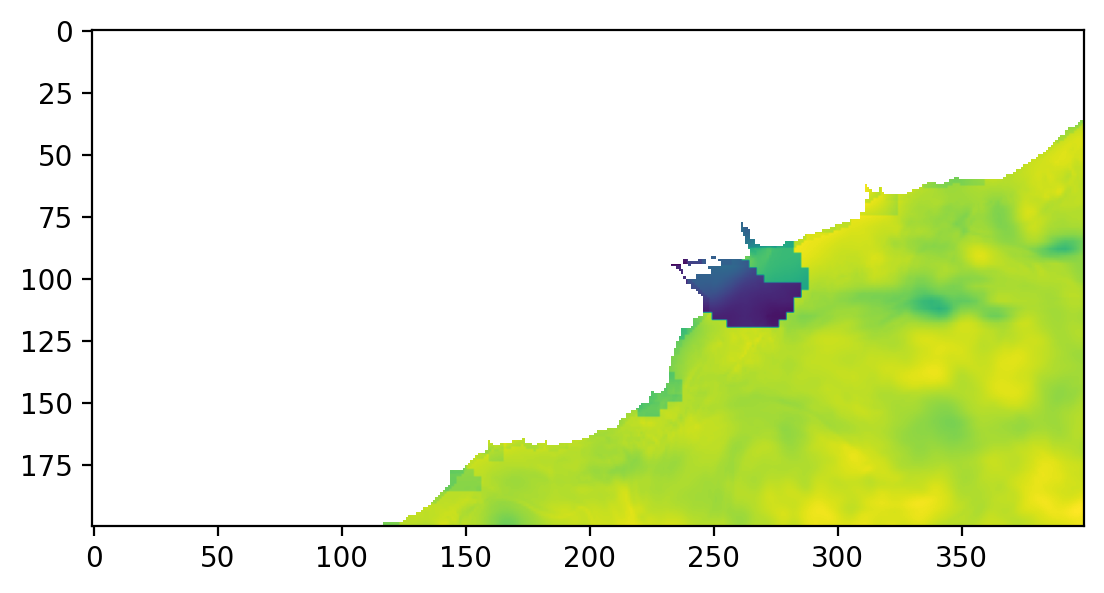

In [106]:
plt.imshow(ds_w_dummy.isel(depthw=0).vovecrtz[1400:1600, 2600:3000])

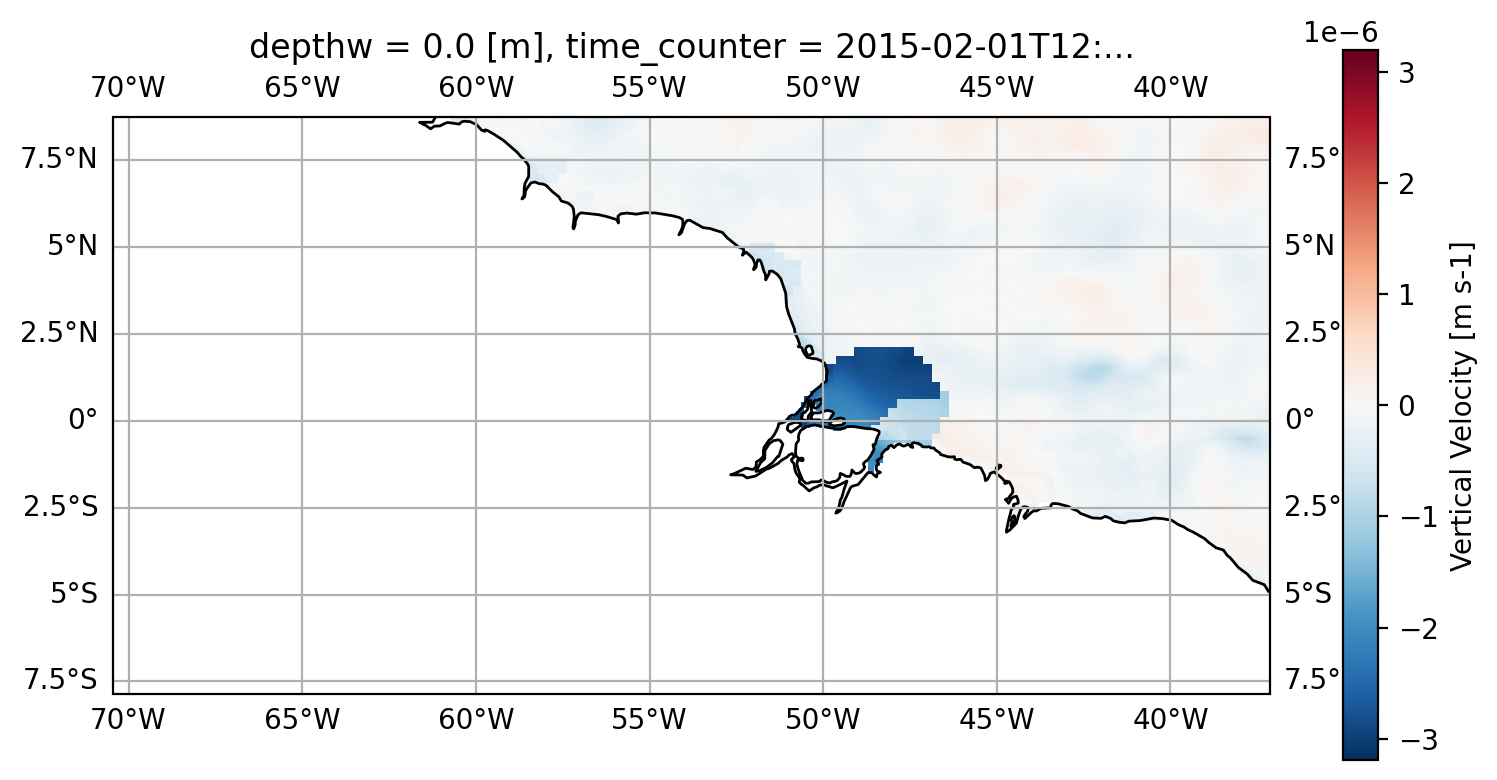

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ds_w_dummy.isel(depthw=0).vovecrtz[1400:1600, 2600:3000].plot(x='nav_lon', y='nav_lat', ax=ax, transform=cart.crs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()

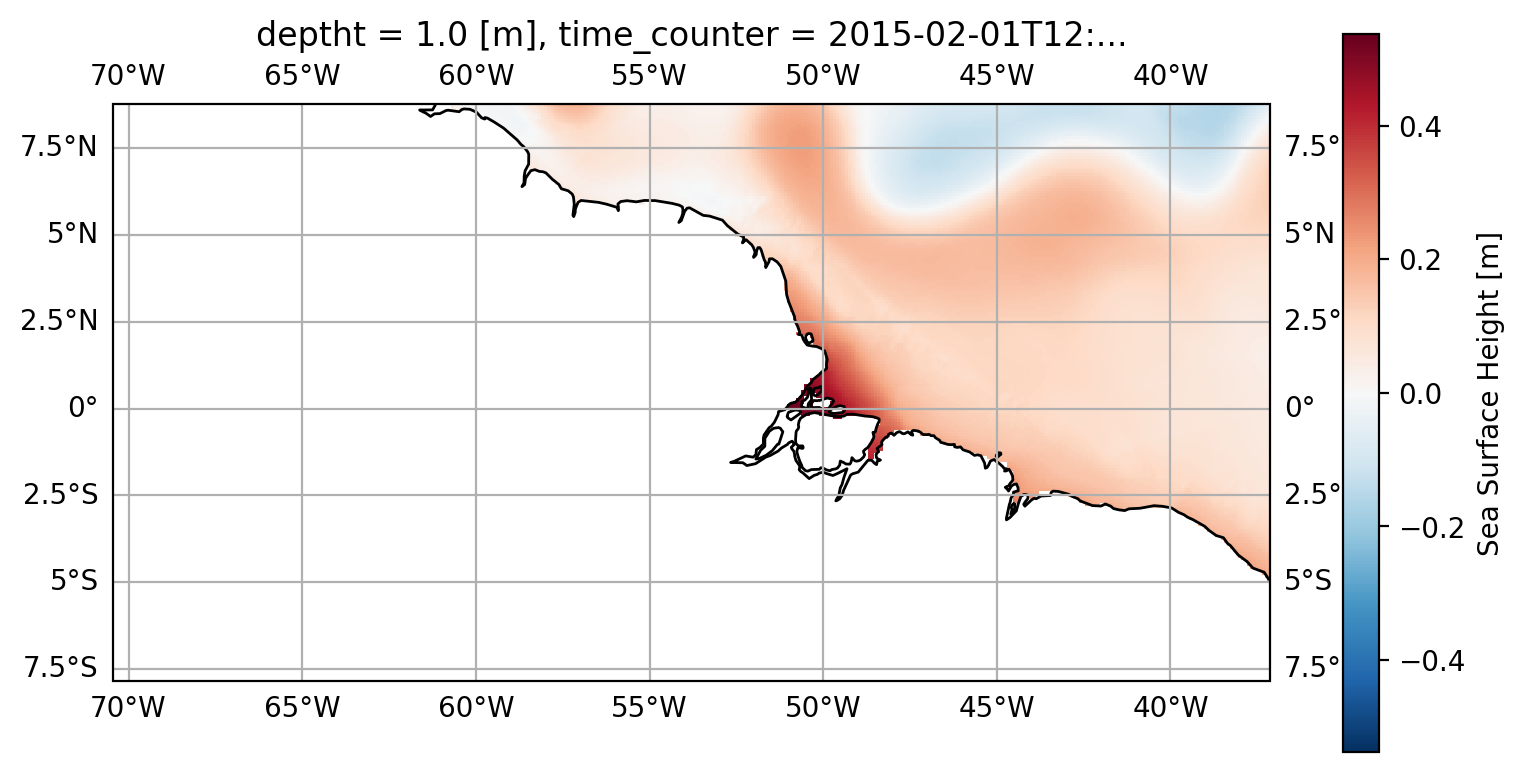

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ds_eta_dummy.sossheig.isel(deptht=0)[1400:1600, 2600:3000].plot(x='nav_lon', y='nav_lat', ax=ax, transform=cart.crs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()

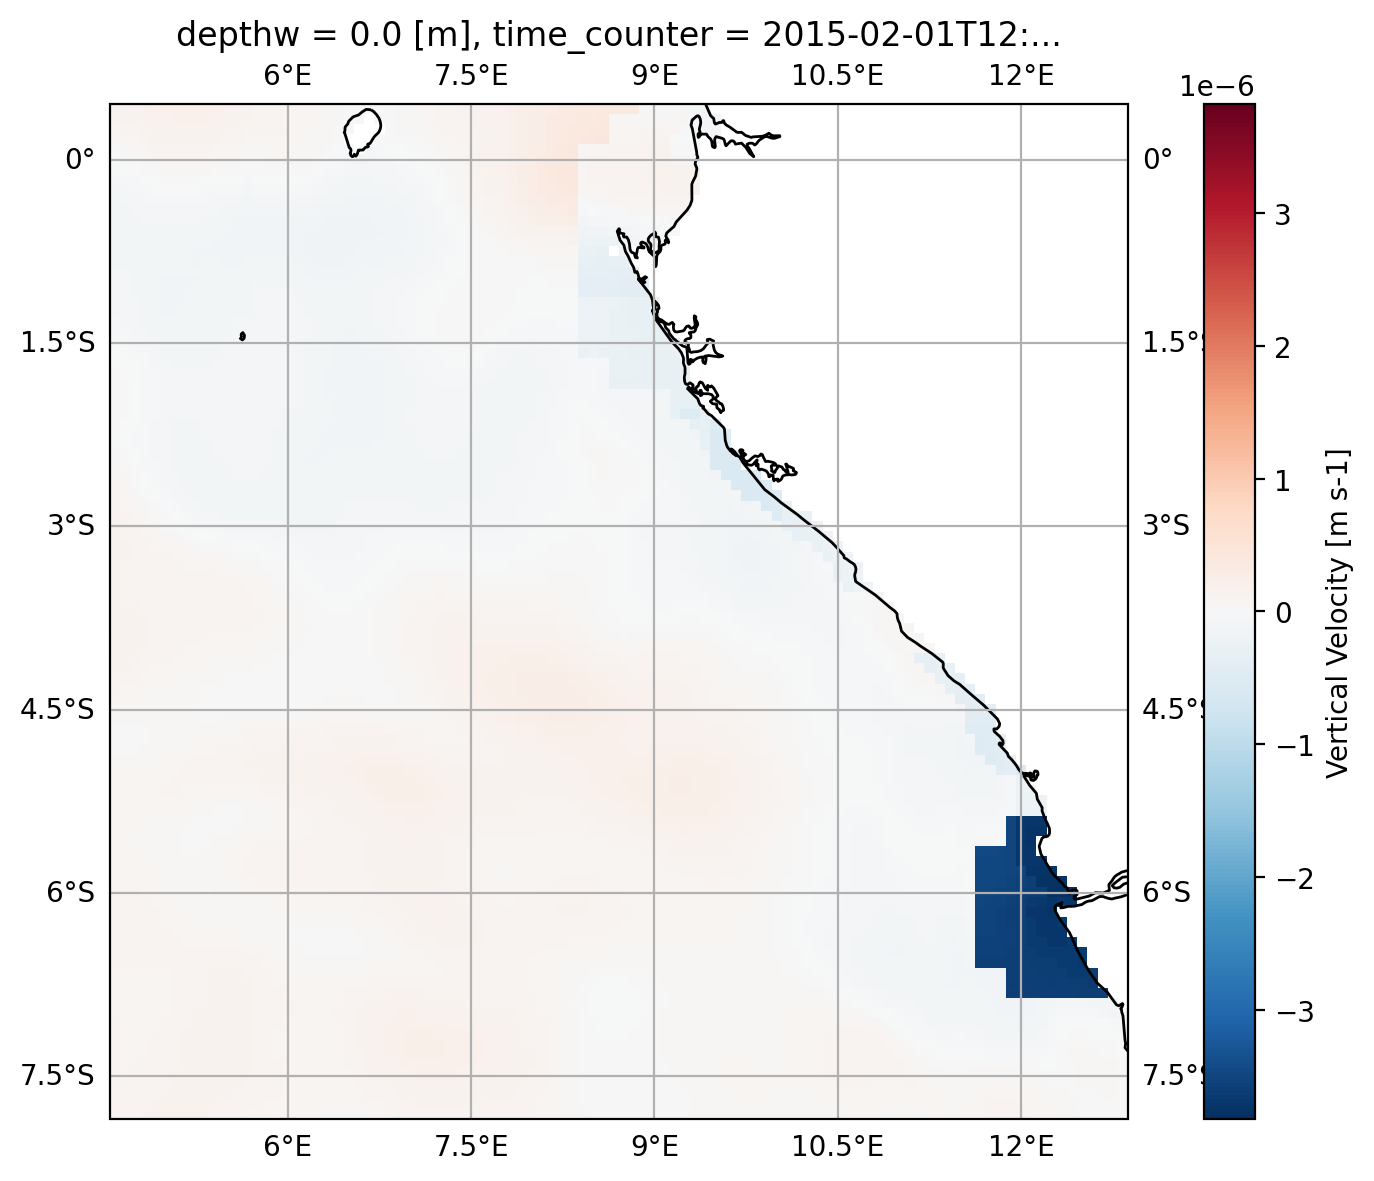

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={'projection': cart.crs.PlateCarree()})
ds_w_dummy.isel(depthw=0).vovecrtz[1400:1500, 3500:3600].plot(x='nav_lon', y='nav_lat', ax=ax, transform=cart.crs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()

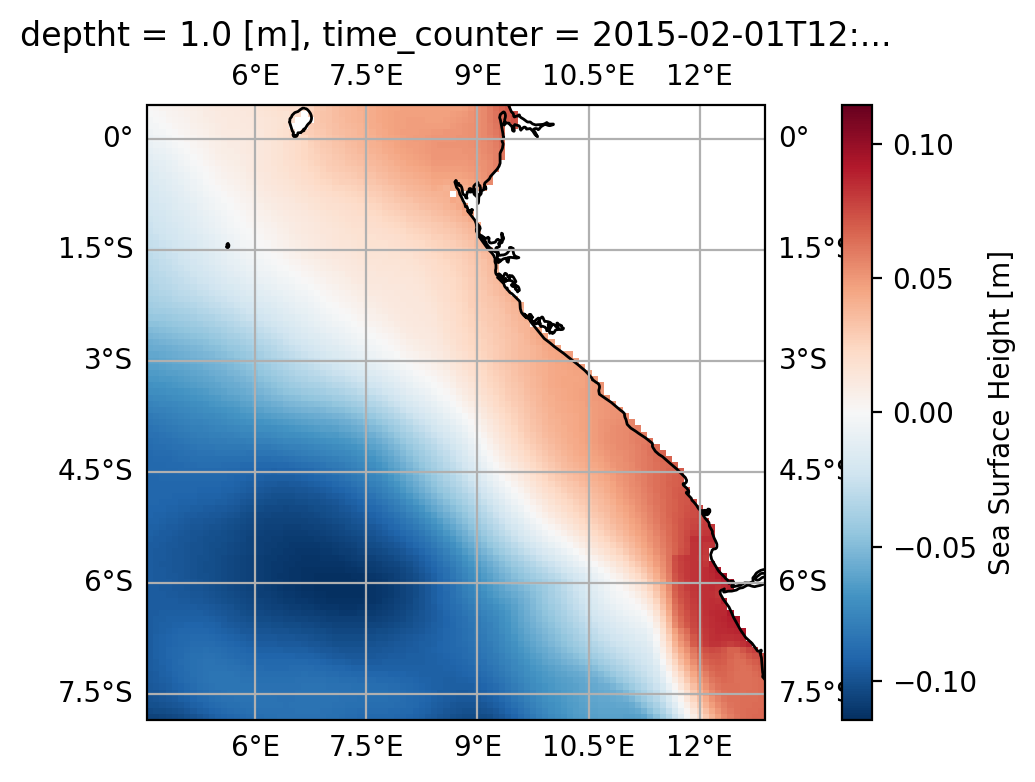

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={'projection': cart.crs.PlateCarree()})
ds_eta_dummy.sossheig.isel(deptht=0)[1400:1500, 3500:3600].plot(x='nav_lon', y='nav_lat', ax=ax, transform=cart.crs.PlateCarree(), cmap='RdBu_r')
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()